In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math as math
import scipy.integrate as integrate
from scipy.interpolate import griddata
from scipy import special
from matplotlib import cm
import emcee

In [2]:
x = np.linspace(0, 10000, 1001) 
y = np.linspace(0, 10000, 1001)
z = np.linspace(0, 10000, 1001)

R = np.sqrt(x**2 + y**2)
r = np.sqrt(x**2 + y**2 + z**2)

#MSP density distributions:

sigma_r = 4500 #pc (average of sigma_r from models in Ploeg et al., Table 2.3)
z_0 = 710 #pc (average of z_0 from models in Ploeg et al., Table 2.3)
N_disk = 6000 #number of pulsars in MW disk, most conservative estimate from Yuan et al. (2014)

#density distribution for MW disk, R^2 = x^2 + y^2 (radial coordinate in Galactic disk), z is height above
#galactic plane, sigma_r and z_0 are parameters:
rho_disk_0 = (N_disk*1.99*10**30)/(4*math.pi*(sigma_r**2)*z_0)
rho_disk = rho_disk_0*(np.exp((-R**2)/(2*(sigma_r**2)))*np.exp(-abs(z)/z_0))

r_0 = 0.22 #pc
rho_0_NSC = 3.3*10**6 #M_sun pc^-3
rho_1_NSC = 8.9*10**7 #M_sun pc^-3 (set so that rho_NSC is continuous at r = 6 pc)

#density distribution for NSC, r^2 = x^2 + y^2 + z^2:
def rho_NSC(R, z, r_0, rho_0_NSC, rho_1_NSC): 
    r = np.sqrt(R**2 + z**2)
    if 6 >= r:
        return (rho_0_NSC)/(1 + (R**2 + z**2)/(r_0**2))
    elif 6 < r <= 200:
        return (rho_1_NSC)/(1 + ((np.sqrt(R**2 + z**2))/r_0)**3)
    elif r > 200:
        return 0.0

#python has a stroke if you don't vectorize things (becuase functions can't take arrays
#as inputs normally)
vrho_NSC = np.vectorize(rho_NSC)
rho_NSC = vrho_NSC(R, z, r_0, rho_0_NSC, rho_1_NSC)

rho_0_NSD = 301 #M_sun pc^-3
rho_1_NSD = 3.53*10**9 #set so that rho_NSD is continuous at r = 120 pc
rho_2_NSD = 5.94*10**24 #set so that rho_NSD is continuous at r = 220 pc

#density distribution for NSD:
def rho_NSD(R, z, rho_0_NSD, rho_1_NSD, rho_2_NSD):
    r = np.sqrt(R**2 + z**2)
    if r == 0:
        return 0.0
    elif r < 120:
        return rho_0_NSD*(r**(-0.1))*(np.exp(-abs(z)/45))
    elif 120 <= r < 220:
        return rho_1_NSD*(r**(-3.5))*(np.exp(-abs(z)/45))
    elif r>= 220:
        return rho_2_NSD*(r**(-10))*(np.exp(-abs(z)/45))
    
vrho_NSD = np.vectorize(rho_NSD)
rho_NSD = vrho_NSD(R, z, rho_0_NSD, rho_1_NSD, rho_2_NSD)

#density distribution for nuclear bulge
rho_nuclear_bulge = rho_NSC + rho_NSD

In [3]:
#numerical integration of densities to find number of MSPs
rho_disk_0 = (N_disk*1.99*10**30)/(4*math.pi*(sigma_r**2)*z_0)
rho_disk_with_jacobian = lambda R, z, t: rho_disk_0*(np.exp((-R**2)/(2*(sigma_r**2)))*np.exp(-abs(z)/z_0))*R

print("rho_disk:")
print(integrate.tplquad(rho_disk_with_jacobian, 0, 2*math.pi, 0, 5000, 0, 5000)[0]) #theta, z, R

rho_nb_part_1 = lambda R, z, t: R*(rho_0_NSC)/(1 + (R**2 + z**2)/(r_0**2))
rho_nb_part_2 = lambda R, z, t: R*(rho_1_NSC)/(1 + ((np.sqrt(R**2 + z**2))/r_0)**3)
rho_nb_part_3 = lambda R, z, t: R*rho_0_NSD*((R**2 + z**2)**(-0.1))*(np.exp(-abs(z)/45))
rho_nb_part_4 = lambda R, z, t: R*rho_1_NSD*((R**2 + z**2)**(-3.5))*(np.exp(-abs(z)/45))
rho_nb_part_5 = lambda R, z, t: R*rho_2_NSD*((R**2 + z**2)**(-10))*(np.exp(-abs(z)/45))


print(" ")
print("rho_nuclear_bulge:")
print(integrate.tplquad(rho_nb_part_1, 0, 2*math.pi, -math.sqrt(6), math.sqrt(6), lambda R, z: -math.sqrt(6-z**2),
                        lambda R, z: math.sqrt(6-z**2))[0] + integrate.tplquad(rho_nb_part_2, 0, 2*math.pi, 
                        -math.sqrt(6), math.sqrt(6), lambda R, z: math.sqrt(6-z**2), lambda R, z: 
                        math.sqrt(200-z**2))[0] + integrate.tplquad(rho_nb_part_3, 0, 2*math.pi, 
                        -2*math.sqrt(30), -0.009, lambda R, z: -math.sqrt(120-z**2),lambda R, z: 
                        math.sqrt(120-z**2))[0] + integrate.tplquad(rho_nb_part_3, 0, 2*math.pi, 
                        0.009, 2*math.sqrt(30), lambda R, z: -math.sqrt(120-z**2),lambda R, z: 
                        math.sqrt(120-z**2))[0] + integrate.tplquad(rho_nb_part_4, 0, 2*math.pi, 
                        -2*math.sqrt(30), -0.009, lambda R, z: math.sqrt(120-z**2), lambda R, z: 
                        math.sqrt(220-z**2))[0] + integrate.tplquad(rho_nb_part_4, 0, 2*math.pi, 
                        0.009, 2*math.sqrt(30), lambda R, z: math.sqrt(120-z**2), lambda R, z: 
                        math.sqrt(220-z**2))[0] + integrate.tplquad(rho_nb_part_5, 0, 2*math.pi, 
                        -2*math.sqrt(55), -0.009, lambda R, z: math.sqrt(220-z**2), lambda R, z: 
                        math.sqrt(5000-z**2))[0] + integrate.tplquad(rho_nb_part_5, 0, 2*math.pi, 
                        0.009, 2*math.sqrt(55), lambda R, z: math.sqrt(220-z**2), lambda R, z: 
                                                                        math.sqrt(5000-z**2))[0])

rho_disk:
2.7473334868924075e+33
 
rho_nuclear_bulge:
10313640.321691435


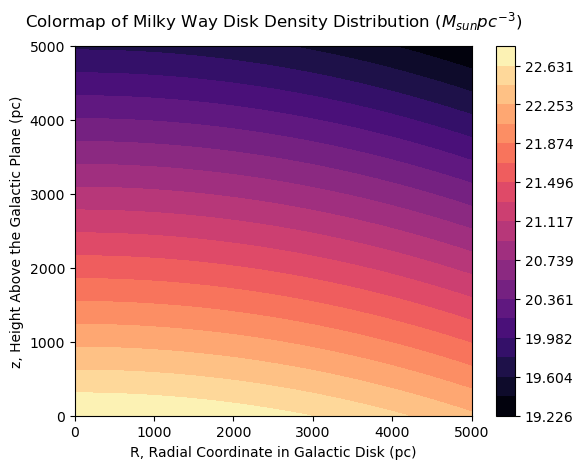

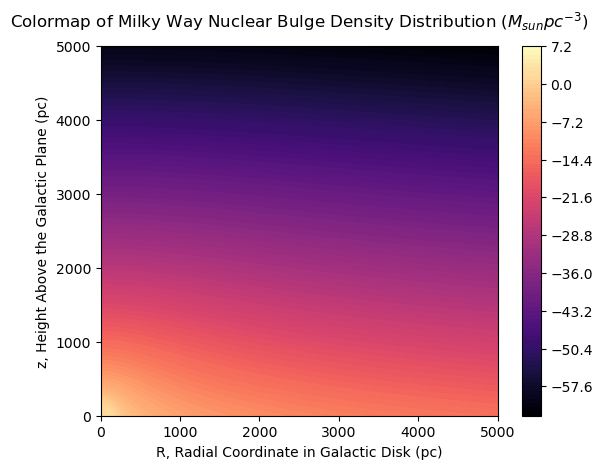

In [4]:
#plot the MSP density distributions to make sure everything seems right
x = np.linspace(0, 5000, 5001) 
y = np.linspace(0, 5000, 5001)
z = np.linspace(0, 5000, 5001)

R = np.sqrt(x**2 + y**2)
r = np.sqrt(x**2 + y**2 + z**2)

#plot the data using np.contourf
R_plot = R
r_plot = r
z_plot = z.reshape(-1, 1)

#rho_disk:
rho_disk_0 = (N_disk*1.99*10**30)/(4*math.pi*(sigma_r**2)*z_0)
rho_disk_plot = rho_disk_0*(np.exp((-R_plot**2)/(2*sigma_r**2))*np.exp(-abs(z_plot)/z_0))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) 
#fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
#cont = ax.contourf(rho_disk_plot, cmap=cm.magma, levels = np.linspace(rho_disk_plot.min(), rho_disk_plot.max(), 20).tolist())
cont = ax.contourf(np.log10(rho_disk_plot), cmap=cm.magma, levels = np.linspace(np.log10(rho_disk_plot).min(), np.log10(rho_disk_plot).max(), 20).tolist())  
#surf = ax.plot_surface(Rgrid, zgrid, rho_disk_plot)
plt.colorbar(cont)

#print(rho_disk_plot)

plt.title("Colormap of Milky Way Disk Density Distribution ($M_{sun} pc^{-3}$)" , y = 1.03)
plt.xlabel("R, Radial Coordinate in Galactic Disk (pc)")
plt.ylabel("z, Height Above the Galactic Plane (pc)")

plt.show()

#rho_nuclear bulge
def rho_NSC_plot(R, z, r_0, rho_0_NSC, rho_1_NSC): 
    r = np.sqrt(R**2 + z**2)
    if 6 >= r:
        return (rho_0_NSC)/(1 + (R**2 + z**2)/(r_0**2))
    elif 6 < r <= 200:
        return (rho_1_NSC)/(1 + ((np.sqrt(R**2 + z**2))/r_0)**3)
    elif r > 200:
        return 0.0
    
def rho_NSD_plot(R, z, rho_0_NSD, rho_1_NSD, rho_2_NSD):
    r = np.sqrt(R**2 + z**2)
    if r == 0:
        return 0.0
    elif r < 120:
        return rho_0_NSD*(r**(-0.1))*(np.exp(-abs(z)/45))
    elif 120 <= r < 220:
        return rho_1_NSD*(r**(-3.5))*(np.exp(-abs(z)/45))
    elif r>= 220:
        return rho_2_NSD*(r**(-10))*(np.exp(-abs(z)/45))
    
vrho_NSD_plot = np.vectorize(rho_NSD_plot)
rho_NSD_plot = vrho_NSD_plot(R_plot, z_plot, rho_0_NSD, rho_1_NSD, rho_2_NSD)
vrho_NSC_plot = np.vectorize(rho_NSC_plot)
rho_NSC_plot = vrho_NSC_plot(R_plot, z_plot, r_0, rho_0_NSC, rho_1_NSC)
rho_nuclear_bulge_plot = rho_NSC_plot + rho_NSD_plot

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
cont = ax.contourf(np.log10(rho_nuclear_bulge_plot), cmap=cm.magma, levels = 100)
plt.colorbar(cont)

plt.ylim(0, 5000)
plt.xlim(0, 5000)
plt.title("Colormap of Milky Way Nuclear Bulge Density Distribution ($M_{sun} pc^{-3}$)", y = 1.03)
plt.xlabel("R, Radial Coordinate in Galactic Disk (pc)")
plt.ylabel("z, Height Above the Galactic Plane (pc)")

plt.show()

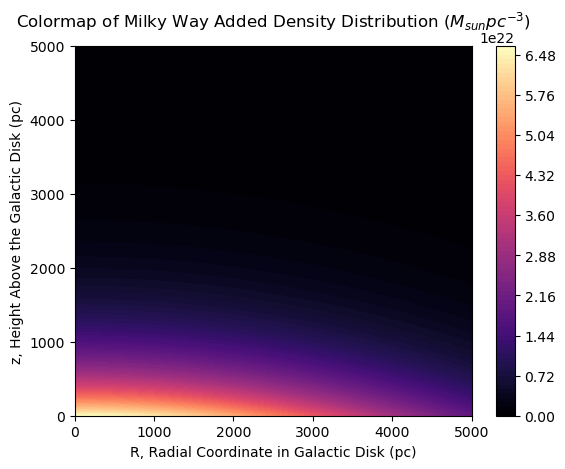

In [5]:
#make a combined plot of all density profiles?
rho_added_plot = (rho_disk_plot + rho_nuclear_bulge_plot)
    
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
cont = ax.contourf(rho_added_plot, cmap=cm.magma, levels = 100)
plt.colorbar(cont)

#plt.xlim(0, 20)
#plt.ylim(0, 20)

plt.title("Colormap of Milky Way Added Density Distribution ($M_{sun} pc^{-3}$)", y = 1.03)
plt.xlabel("R, Radial Coordinate in Galactic Disk (pc)")
plt.ylabel("z, Height Above the Galactic Disk (pc)")

plt.show()

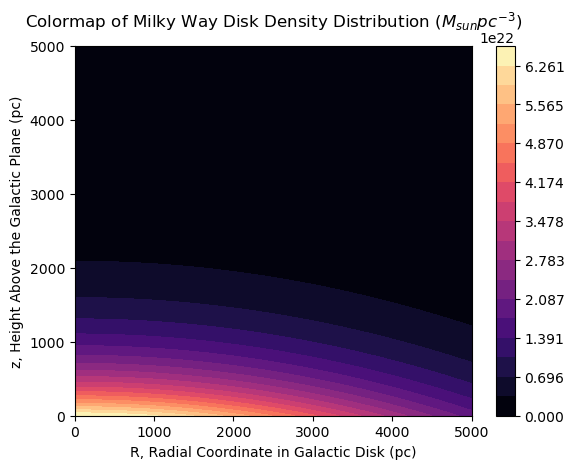

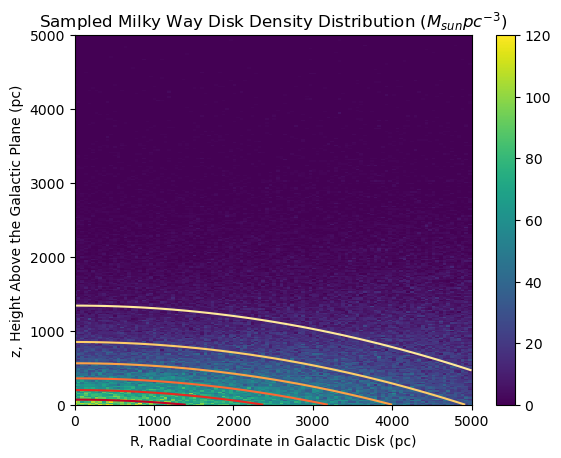

In [6]:
#try MCMC sampling on the conditional probabilities of rho_disk
#plot the test function
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) 
cont = ax.contourf(rho_disk_plot, cmap=cm.magma, levels = np.linspace(rho_disk.min(), rho_disk.max(), 20).tolist())  
plt.colorbar(cont)

plt.title("Colormap of Milky Way Disk Density Distribution ($M_{sun} pc^{-3}$)" , y = 1.03)
plt.xlabel("R, Radial Coordinate in Galactic Disk (pc)")
plt.ylabel("z, Height Above the Galactic Plane (pc)")
plt.show()

#define conditional probabilities
def func_z_bar_R(z, z_0): 
    return np.log((np.exp(-abs(z)/z_0))/(2*z_0))

def func_R_bar_z(R, sigma_r): 
    return np.log((np.exp(-(R**2)/(2*sigma_r**2)))/(2*math.pi*sigma_r))

#try MCMC sampling using emcee
ndim = 1
nwalkers = 32
p0 = np.random.rand(nwalkers, ndim)

func_z_bar_R_sampler = emcee.EnsembleSampler(nwalkers, ndim, func_z_bar_R, args=[z_0])
func_z_bar_R_state = func_z_bar_R_sampler.run_mcmc(p0, 100)
func_z_bar_R_sampler.reset()

func_z_bar_R_sampler.run_mcmc(func_z_bar_R_state, 40000)

samples1 = func_z_bar_R_sampler.get_chain(flat=True)

func_R_bar_z_sampler = emcee.EnsembleSampler(nwalkers, ndim, func_R_bar_z, args=[sigma_r])
func_R_bar_z_state = func_R_bar_z_sampler.run_mcmc(p0, 100)
func_R_bar_z_sampler.reset()

func_R_bar_z_sampler.run_mcmc(func_R_bar_z_state, 40000)

samples2 = func_R_bar_z_sampler.get_chain(flat=True)
plt.hist2d(samples2[:, 0], samples1[:, 0], bins = 1000) #x = R, y = z
plt.colorbar()

#plot counters of rho_disk to check accuracy of sampling
plt.contour(rho_disk_plot, cmap = "YlOrRd")
plt.title("Sampled Milky Way Disk Density Distribution ($M_{sun} pc^{-3}$)")
plt.xlabel("R, Radial Coordinate in Galactic Disk (pc)")
plt.ylabel("z, Height Above the Galactic Plane (pc)")
plt.xlim(0, 5000)
plt.ylim(0, 5000)
#plt.gca().set_yticks([])
plt.show()

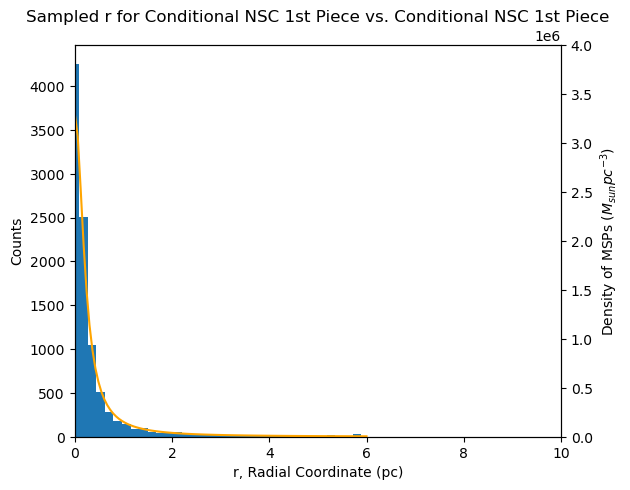

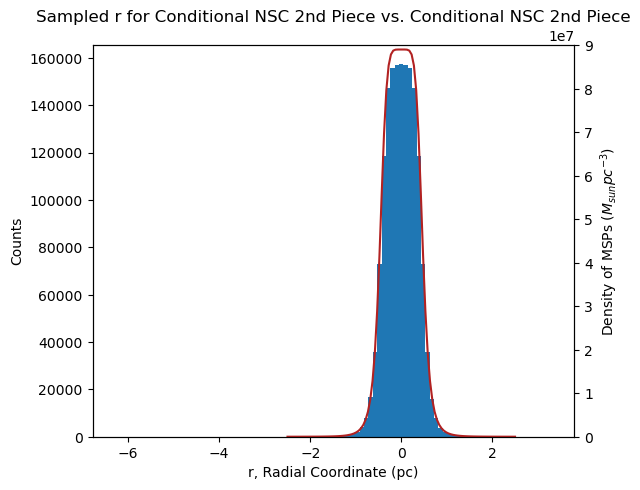

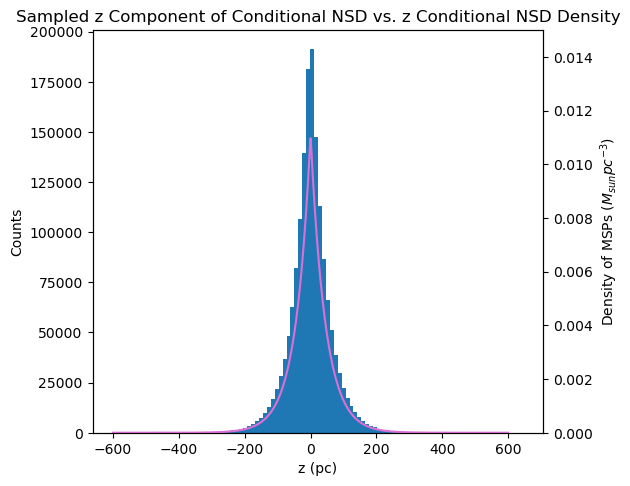

/var/folders/0r/2bwbsj0536qfybj3dfw_6v840000gn/T/ipykernel_30585/3180941729.py:19: RuntimeWarning: divide by zero encountered in power
  return (0.0121)*(r**(-0.1))


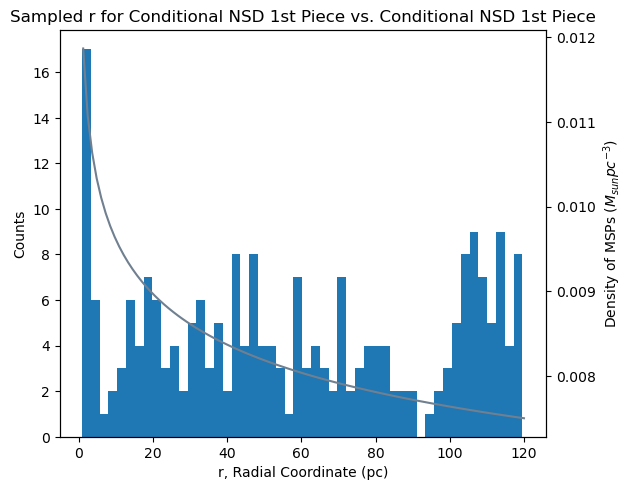

In [7]:
#1D MCMC sample the nuclear bulge population 
def MC_rho_NSC_1(r, r_0, rho_0_NSC, rho_1_NSC):
    if (r <= 6):
        return np.log((rho_0_NSC)/(1 + (r**2)/(r_0**2)))
    else:
        return -np.inf
def MC_rho_NSC_2(r, r_0, rho_0_NSC, rho_1_NSC):
    return np.log((rho_1_NSC)/(1 + ((r**2)/r_0)**3))

#for plotting comparisons
def MC_rho_NSC_1p(r, r_0, rho_0_NSC, rho_1_NSC):
    return (rho_0_NSC)/(1 + (r**2)/(r_0**2))
def MC_rho_NSC_2p(r, r_0, rho_0_NSC, rho_1_NSC):
    return (rho_1_NSC)/(1 + ((r**2)/r_0)**3)

def MC_rho_NSD_zp(z):
    return np.exp(-abs(z)/45)/90
def MC_rho_NSD_r1p(r):
    return (0.0121)*(r**(-0.1))

#sample the NSC part first
ndim = 1
nwalkers = 32
p0 = np.random.rand(nwalkers, ndim)

MC_rho_NSC_1_sampler = emcee.EnsembleSampler(nwalkers, ndim, MC_rho_NSC_1, args=[r_0, rho_0_NSC, rho_1_NSC])
MC_rho_NSC_1_state = MC_rho_NSC_1_sampler.run_mcmc(p0, 100)
MC_rho_NSC_1_sampler.reset()

MC_rho_NSC_1_sampler.run_mcmc(MC_rho_NSC_1_state, 500)

MC_rho_NSC_2_sampler = emcee.EnsembleSampler(nwalkers, ndim, MC_rho_NSC_2, args=[r_0, rho_0_NSC, rho_1_NSC])
MC_rho_NSC_2_state = MC_rho_NSC_2_sampler.run_mcmc(p0, 100)
MC_rho_NSC_2_sampler.reset()

MC_rho_NSC_2_sampler.run_mcmc(MC_rho_NSC_2_state, 50000)

samples_NSC_1 = MC_rho_NSC_1_sampler.get_chain(flat=True)
samples_NSC_2 = MC_rho_NSC_2_sampler.get_chain(flat=True)

fig, ax1 = plt.subplots()

ax1.hist(samples_NSC_1[:, 0], 500)
ax1.set_xlabel("r, Radial Coordinate (pc)")
ax1.set_ylabel("Counts")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.plot(np.linspace(0, 6, 100), MC_rho_NSC_1p(np.linspace(0, 6, 100), r_0, rho_0_NSC, rho_1_NSC), color = "orange")
ax2.set_ylabel("Density of MSPs ($M_{sun} pc^{-3}$)")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Sampled r for Conditional NSC 1st Piece vs. Conditional NSC 1st Piece")
#plt.legend()
plt.xlim(0, 10)
plt.ylim(0, 4e6)
plt.show()

fig, ax1 = plt.subplots()

ax1.hist(samples_NSC_2[:, 0], 100)
ax1.set_xlabel("r, Radial Coordinate (pc)")
ax1.set_ylabel("Counts")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.plot(np.linspace(-2.5, 2.5, 100), MC_rho_NSC_2p(np.linspace(-2.5, 2.5, 100), r_0, rho_0_NSC, rho_1_NSC), color = "firebrick")
ax2.set_ylabel("Density of MSPs ($M_{sun} pc^{-3}$)")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Sampled r for Conditional NSC 2nd Piece vs. Conditional NSC 2nd Piece")
plt.ylim(0, 9e7)
#plt.legend()
plt.show()

#do a wierd r and z 2D sampling
def MC_rho_NSD_z(z):
    return np.log(np.exp(-abs(z)/45)/90)
def MC_rho_NSD_r1(r):
    if (0 < r < 120):
        return np.log((0.0121)*(r**(-0.1)))
    else:
        return -np.inf

#now the NSD part, sample in both r and z
ndim = 1
nwalkers = 32
p0 = np.random.rand(nwalkers, ndim)

MC_rho_NSD_z_sampler = emcee.EnsembleSampler(nwalkers, ndim, MC_rho_NSD_z)
MC_rho_NSD_z_state = MC_rho_NSD_z_sampler.run_mcmc(p0, 100)
MC_rho_NSD_z_sampler.reset()

MC_rho_NSD_z_sampler.run_mcmc(MC_rho_NSD_z_state, 50000)
samples_NSD_z = MC_rho_NSD_z_sampler.get_chain(flat=True)

MC_rho_NSD_r1_sampler = emcee.EnsembleSampler(nwalkers, ndim, MC_rho_NSD_r1)
MC_rho_NSD_r1_state = MC_rho_NSD_r1_sampler.run_mcmc(p0, 50)
MC_rho_NSD_r1_sampler.reset()

MC_rho_NSD_r1_sampler.run_mcmc(MC_rho_NSD_r1_state, 7)

samples_NSD_r1 = MC_rho_NSD_r1_sampler.get_chain(flat=True)

fig, ax1 = plt.subplots()

ax1.hist(samples_NSD_z[:, 0], 100)
ax1.set_xlabel("z (pc)")
ax1.set_ylabel("Counts")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.plot(np.linspace(-600, 600, 1000), MC_rho_NSD_zp(np.linspace(-600, 600, 1000)), color = "orchid")
ax2.set_ylabel("Density of MSPs ($M_{sun} pc^{-3}$)")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Sampled z Component of Conditional NSD vs. z Conditional NSD Density")
plt.ylim(0, 0.015)
#plt.legend()
plt.show()

fig, ax1 = plt.subplots()

ax1.hist(samples_NSD_r1[:, 0], 50)
ax1.set_xlabel("r, Radial Coordinate (pc)")
ax1.set_ylabel("Counts")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.plot(np.linspace(0, 120, 100), MC_rho_NSD_r1p(np.linspace(0, 120, 100)), color = "slategray")
ax2.set_ylabel("Density of MSPs ($M_{sun} pc^{-3}$)")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Sampled r for Conditional NSD 1st Piece vs. Conditional NSD 1st Piece")
#plt.legend()
plt.show()

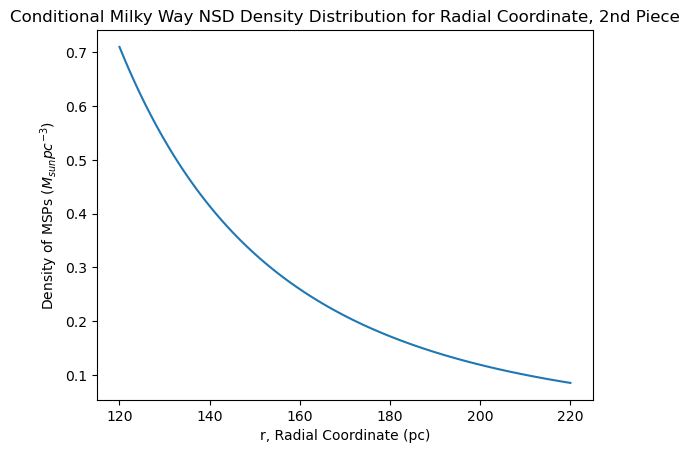

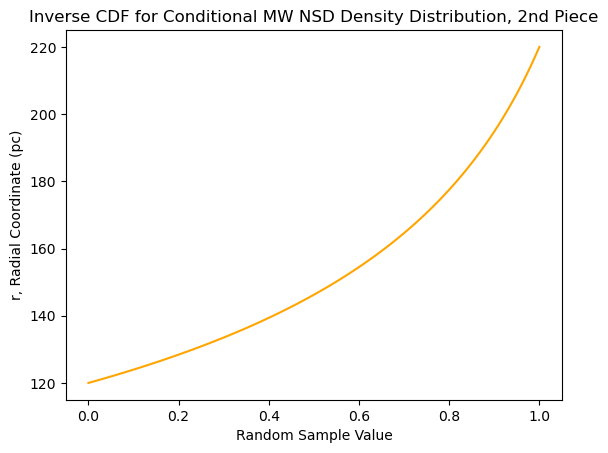

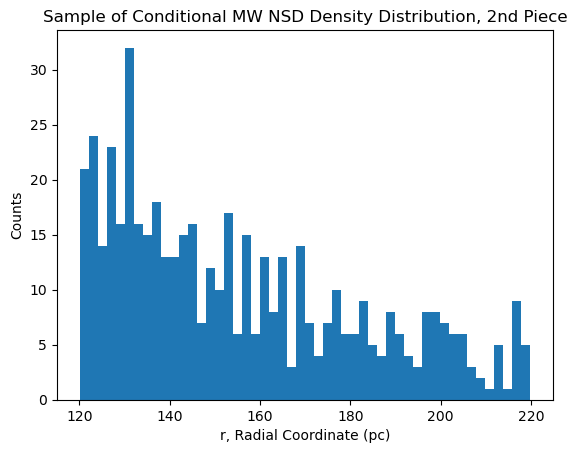

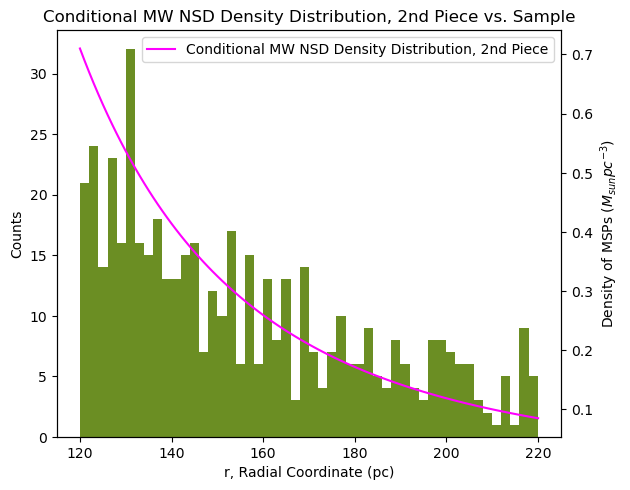

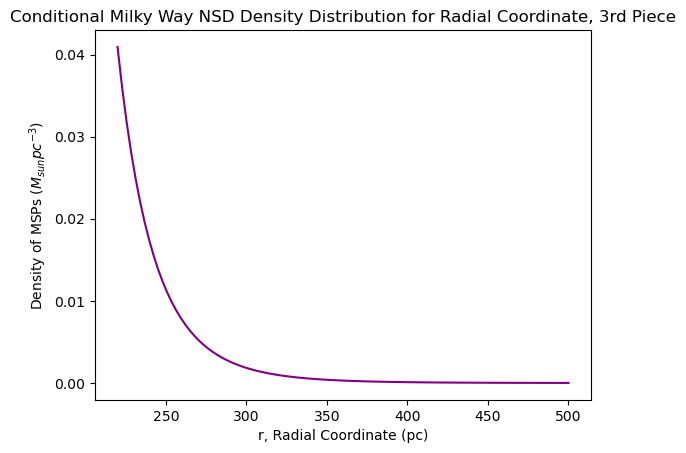

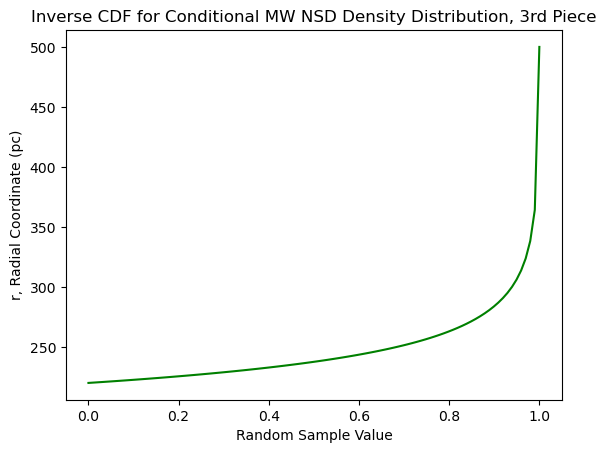

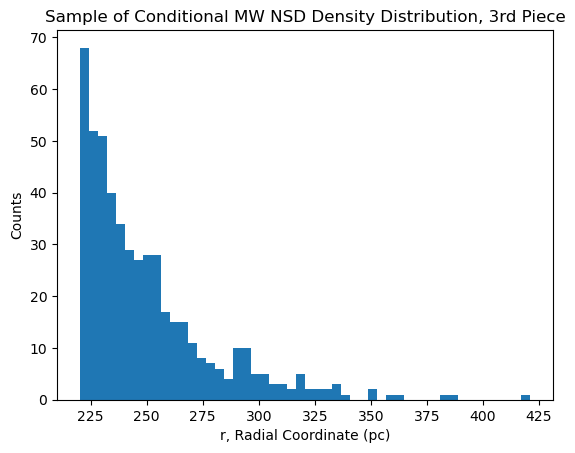

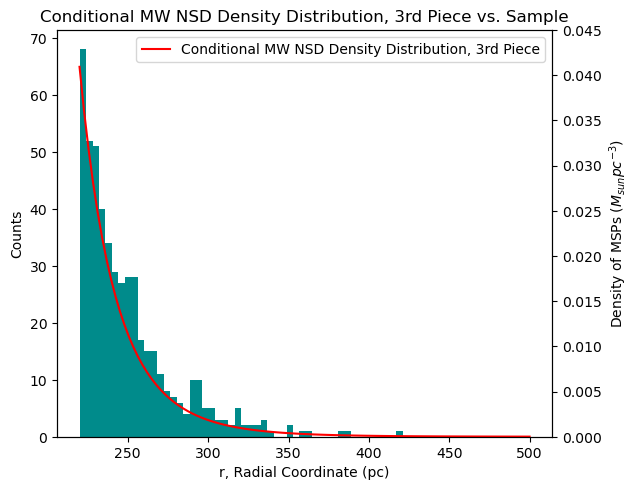

In [8]:
#inverse transform sampling on two later NSD functions, b/c the MCMC sampler was getting stuck
#sample the NSD 2nd piece (in the form of a power law)
def NSD_2_piece(r, a, c):
    return c*r**(-a)

plt.plot(np.linspace(120, 220, 101), NSD_2_piece(np.linspace(120, 220, 101), 3.5, 1.344*10**7))
plt.title("Conditional Milky Way NSD Density Distribution for Radial Coordinate, 2nd Piece")
plt.xlabel("r, Radial Coordinate (pc)")
plt.ylabel("Density of MSPs ($M_{sun} pc^{-3}$)")
plt.show()

#inverse CDF given by a specific power function related form of the inv_cdf
def inv_cdf2(x, a):
    return ((220**(1-a) - 120**(1-a))*x + 120**(1-a))**(1/(1-a))

plt.plot(np.linspace(0, 1, 100), inv_cdf2(np.linspace(0, 1, 100), 3.5), color = "orange")
plt.title("Inverse CDF for Conditional MW NSD Density Distribution, 2nd Piece")
plt.xlabel("Random Sample Value")
plt.ylabel("r, Radial Coordinate (pc)")
plt.show()

#generate a random sample using inverse CDF
sample = np.random.rand(500)
plt.hist(inv_cdf2(sample, 3.5), 50)
plt.title("Sample of Conditional MW NSD Density Distribution, 2nd Piece")
plt.xlabel("r, Radial Coordinate (pc)")
plt.ylabel("Counts")
plt.show()

#plot both on top of eachother to see the accuracy
fig, ax1 = plt.subplots()

ax1.hist(inv_cdf2(sample, 3.5), 50, color = "olivedrab")
ax1.set_xlabel("r, Radial Coordinate (pc)")
ax1.set_ylabel("Counts")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.plot(np.linspace(120, 220, 101), NSD_2_piece(np.linspace(120, 220, 101), 3.5, 1.344*10**7), color = "magenta", label = "Conditional MW NSD Density Distribution, 2nd Piece")
ax2.set_ylabel("Density of MSPs ($M_{sun} pc^{-3}$)")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Conditional MW NSD Density Distribution, 2nd Piece vs. Sample")
plt.legend()
plt.show()

#sample the NSD 3rd piece
def NSD_3_piece(r, a, c):
    return c*r**(-a)

plt.plot(np.linspace(220, 500, 101), NSD_3_piece(np.linspace(220, 500, 101), 10, 1.087*10**22), color = "purple")
plt.title("Conditional Milky Way NSD Density Distribution for Radial Coordinate, 3rd Piece")
plt.xlabel("r, Radial Coordinate (pc)")
plt.ylabel("Density of MSPs ($M_{sun} pc^{-3}$)")
plt.show()

#inverse CDF given by a specific power function realted form of the inv_cdf
def inv_cdf3(x, a):
    return ((500**(1-a) - 220**(1-a))*x + 220**(1-a))**(1/(1-a))

plt.plot(np.linspace(0, 1, 100), inv_cdf3(np.linspace(0, 1, 100), 10), color = "green")
plt.title("Inverse CDF for Conditional MW NSD Density Distribution, 3rd Piece")
plt.xlabel("Random Sample Value")
plt.ylabel("r, Radial Coordinate (pc)")
plt.show()

#generate a random sample using inverse CDF
sample = np.random.rand(500)
plt.hist(inv_cdf3(sample, 10), 50)
plt.title("Sample of Conditional MW NSD Density Distribution, 3rd Piece")
plt.xlabel("r, Radial Coordinate (pc)")
plt.ylabel("Counts")
plt.show()

#plot both on top of eachother to see the accuracy
fig, ax1 = plt.subplots()

ax1.hist(inv_cdf3(sample, 10), 50, label = "Sample", color = "darkcyan")
ax1.set_xlabel("r, Radial Coordinate (pc)")
ax1.set_ylabel("Counts")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.plot(np.linspace(220, 500, 101), NSD_3_piece(np.linspace(220, 500, 101), 10, 1.087*10**22), color = "red", label = "Conditional MW NSD Density Distribution, 3rd Piece")
ax2.set_ylabel("Density of MSPs ($M_{sun} pc^{-3}$)")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Conditional MW NSD Density Distribution, 3rd Piece vs. Sample")
ax2.set_ylim(0, 0.045)
plt.legend()
plt.show()

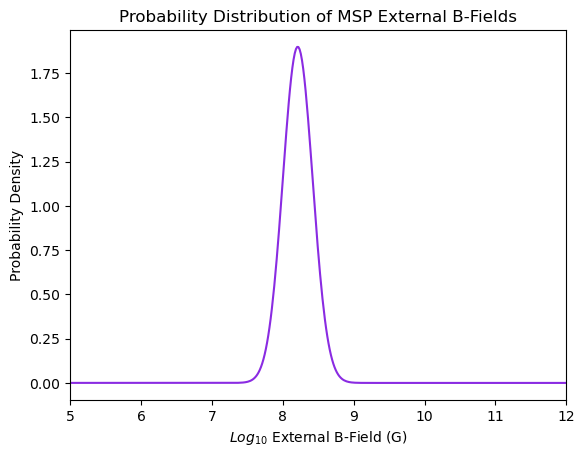

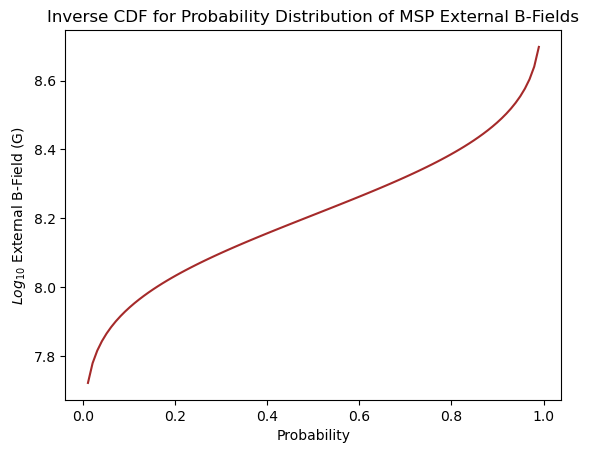

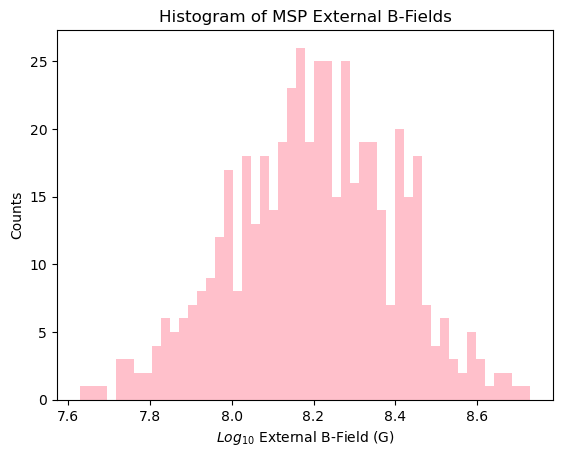

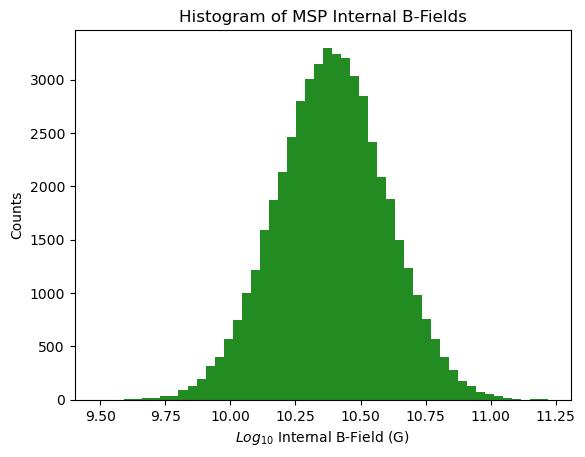

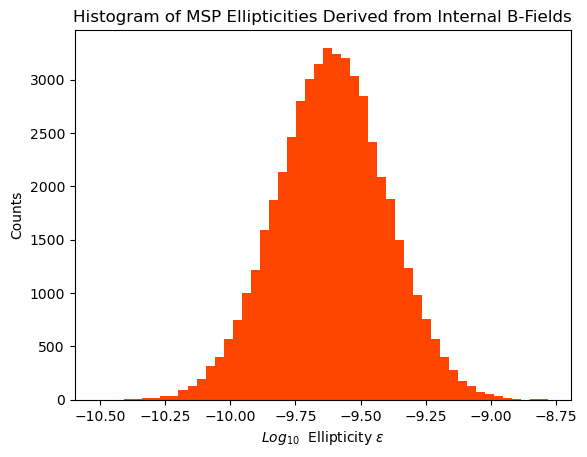

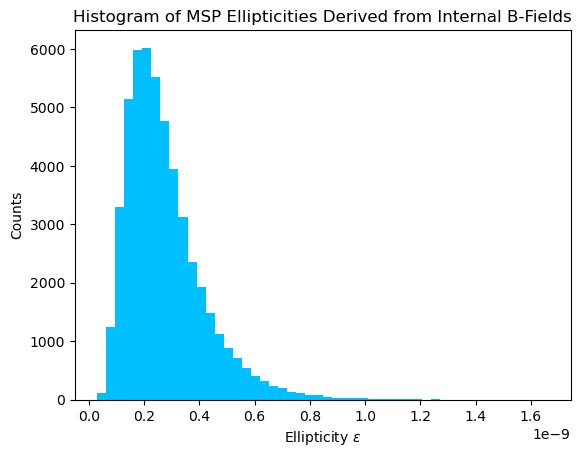

In [9]:
#plot the moment of inertia (ellipticity?) distribution for MSPs

#to find the ellipticity distribution, Miller et al. uses two methods. We'll adopt the 1st:
#assume the deformations are caused by the internal magnetic field

#averages of log10(B_med) and sigma_B from Ploeg et al., which is a fairly different range than
#what Miller et al. has for their B-fields
log_10_B_med = 8.21 #B_med in G 
sigma_B = 0.21 

#we have to inverse transform sample this to get a distribution of B fields
def p_B(log_10_B, sigma_B, log_10_B_med): 
    return (1/((np.sqrt(2*np.pi)*sigma_B)))*np.exp(-((log_10_B - log_10_B_med)**2)/(2*(sigma_B**2)))

plt.plot(np.linspace(0, 17, 1000), p_B(np.linspace(0, 17, 1000), sigma_B, log_10_B_med), color = "blueviolet")
plt.title("Probability Distribution of MSP External B-Fields")
plt.xlabel("$Log_{10}$ External B-Field (G)")
plt.ylabel("Probability Density")
plt.xlim(5, 12)
plt.show()

def inv_cdf_p_B(log_10_B, sigma_B, log_10_B_med):
    return log_10_B_med - math.sqrt(2)*sigma_B*special.erfinv(-2*log_10_B + 1)

plt.plot(np.linspace(0, 1, 100), inv_cdf_p_B(np.linspace(0, 1, 100), sigma_B, log_10_B_med), color = "brown")
plt.title("Inverse CDF for Probability Distribution of MSP External B-Fields")
plt.ylabel("$Log_{10}$ External B-Field (G)")
plt.xlabel("Probability")
plt.show()

#sample the distribution
sample = np.random.rand(500)
plt.hist(inv_cdf_p_B(sample, sigma_B, log_10_B_med), 50, color = "pink")
plt.title("Histogram of MSP External B-Fields")
plt.xlabel("$Log_{10}$ External B-Field (G)")
plt.ylabel("Counts")
plt.show()

#so B_ext is:
sample = np.random.rand(50000)
B_log_ext = inv_cdf_p_B(sample, sigma_B, log_10_B_med)
B_ext = 10**B_log_ext

#according to Miller et al. B_int = 150*B_ext (conservatively, could be up to 10^4 times greater):
#try 150, 1000, 10,000 times to see if conincides with min. ellipticity of 10^-9 from Woan, etc.?
B_int = 150*B_ext

plt.hist(np.log10(B_int), 50, color = "forestgreen")
plt.title("Histogram of MSP Internal B-Fields")
plt.xlabel("$Log_{10}$ Internal B-Field (G)")
plt.ylabel("Counts")
plt.show()

#ellipticity is then given by 10^-8*(b_int*(10^-12)), or in log scale:
rescaled_B_int = B_int/(10**12)
epsilon_B = (10**-8)*rescaled_B_int

#find the log10(ellipticity):
epsilon_log = np.log10(epsilon_B)

#plot log10(ellipticity)
plt.hist(epsilon_log, 50, color = "orangered")
plt.title("Histogram of MSP Ellipticities Derived from Internal B-Fields")
plt.xlabel("$Log_{10}$  Ellipticity $\epsilon$")
plt.ylabel("Counts")
plt.show()

#plot regular ellipticity
plt.hist(epsilon_B, 50, color = "deepskyblue")
plt.title("Histogram of MSP Ellipticities Derived from Internal B-Fields")
plt.xlabel("Ellipticity $\epsilon$")
plt.ylabel("Counts")
plt.show()

In [10]:
#convert the MW nuclear bulge population from r (defined as r^2 = x^2 + y^2 + z^2
#or r^2 = R^2 + z^2) and z coords. to R and z coords

#the NSC population only depends on r --> we'll have to generate a random sample 
#of z values in a certain range and solve for R

#from the nuclear bulge plot, it looks as though z dies off before 5 kpc
NSC_sample_z_1 = np.random.randint(0, 5, 5000) 
NSC_sample_z_2 = np.random.randint(0, 5, 5000)

NSC_1_sample_r = np.random.choice(samples_NSC_1[:, 0], size = 5000) 
NSC_2_sample_r = np.random.choice(samples_NSC_2[:, 0], size = 5000)

NSC_1_sample_R = np.sqrt(NSC_1_sample_r**2 - NSC_sample_z_1**2)[~np.isnan((np.sqrt(NSC_1_sample_r**2 - NSC_sample_z_1**2)))]
NSC_2_sample_R = np.sqrt(NSC_2_sample_r**2 - NSC_2_sample_r**2)[~np.isnan((np.sqrt(NSC_2_sample_r**2 - NSC_2_sample_r**2)))]

NSC_size = NSC_1_sample_R.size + NSC_2_sample_R.size
#print(NSC_size)

#the NSD population has r and z dependence --> use the sampled z component to solve for R
NSD_z_1_sample = np.random.choice(samples_NSD_z[:, 0], size = 1000) 
NSD_z_2_sample = np.random.choice(samples_NSD_z[:, 0], size = 1000)
NSD_z_3_sample = np.random.choice(samples_NSD_z[:, 0], size = 1000)

NSD_1_sample_r = np.random.choice(samples_NSD_r1[:, 0], size = 1000)
NSD_2_sample_r = np.random.choice(inv_cdf2(sample, 3.5), size = 1000) 
NSD_3_sample_r = np.random.choice(inv_cdf3(sample, 10), size = 1000) 

NSD_1_sample_R = np.sqrt(NSD_1_sample_r**2 - NSD_z_1_sample**2)[~np.isnan(np.sqrt(NSD_1_sample_r**2 - NSD_z_1_sample**2))]
NSD_2_sample_R = np.sqrt(NSD_2_sample_r**2 - NSD_z_2_sample**2)[~np.isnan(np.sqrt(NSD_2_sample_r**2 - NSD_z_2_sample**2))]
NSD_3_sample_R = np.sqrt(NSD_3_sample_r**2 - NSD_z_3_sample**2)[~np.isnan(np.sqrt(NSD_3_sample_r**2 - NSD_z_3_sample**2))]

NSD_size = NSD_1_sample_R.size + NSD_2_sample_R.size + NSD_3_sample_R.size
#print(NSD_size)

NB_size = NSC_size + NSD_size
print(NB_size)

#find the new MW disk population R and z values
#assume best sample size is in range of 36,000 - 47,000 (say 40,000 total) from Holst et al.
MWD_size = 4000000 - NB_size 
print(MWD_size)

MWD_R = np.random.choice(samples2[:, 0], size = MWD_size)
MWD_z = np.random.choice(samples1[:, 0], size = MWD_size)

R_GC = np.concatenate((MWD_R, NSC_1_sample_R, NSC_2_sample_R, NSD_1_sample_R, NSD_2_sample_R, NSD_3_sample_R))
z_GC = np.concatenate((MWD_z, NSC_sample_z_1[~np.isnan((np.sqrt(NSC_1_sample_r**2 - NSC_sample_z_1**2)))], 
                    NSC_sample_z_2[~np.isnan((np.sqrt(NSC_2_sample_r**2 - NSC_2_sample_r**2)))], 
                    NSD_z_1_sample[~np.isnan(np.sqrt(NSD_1_sample_r**2 - NSD_z_1_sample**2))], 
                    NSD_z_2_sample[~np.isnan(np.sqrt(NSD_2_sample_r**2 - NSD_z_2_sample**2))], 
                    NSD_z_3_sample[~np.isnan(np.sqrt(NSD_3_sample_r**2 - NSD_z_3_sample**2))]))

print(R_GC.size)
print(z_GC.size)

r_sun = 8500 #pc

#take phi as usual for the dist.
phi_range = np.linspace(0, 2*math.pi, 4000000)
phi_GC = np.random.choice(phi_range, size = R_GC.size)

#now convert to cartesian coordinates and into galactic coords.
x = R_GC*np.cos(phi_GC) - r_sun
y = R_GC*np.sin(phi_GC)
z = z_GC

#now find the dist in galactic coords.
dist = np.sqrt(x**2 + y**2 +z**2)

MSP_pop_size = dist.size
print(MSP_pop_size)
print(np.average(dist))

/var/folders/0r/2bwbsj0536qfybj3dfw_6v840000gn/T/ipykernel_30585/3196032099.py:14: RuntimeWarning: invalid value encountered in sqrt
  NSC_1_sample_R = np.sqrt(NSC_1_sample_r**2 - NSC_sample_z_1**2)[~np.isnan((np.sqrt(NSC_1_sample_r**2 - NSC_sample_z_1**2)))]
/var/folders/0r/2bwbsj0536qfybj3dfw_6v840000gn/T/ipykernel_30585/3196032099.py:29: RuntimeWarning: invalid value encountered in sqrt
  NSD_1_sample_R = np.sqrt(NSD_1_sample_r**2 - NSD_z_1_sample**2)[~np.isnan(np.sqrt(NSD_1_sample_r**2 - NSD_z_1_sample**2))]
/var/folders/0r/2bwbsj0536qfybj3dfw_6v840000gn/T/ipykernel_30585/3196032099.py:30: RuntimeWarning: invalid value encountered in sqrt
  NSD_2_sample_R = np.sqrt(NSD_2_sample_r**2 - NSD_z_2_sample**2)[~np.isnan(np.sqrt(NSD_2_sample_r**2 - NSD_z_2_sample**2))]
/var/folders/0r/2bwbsj0536qfybj3dfw_6v840000gn/T/ipykernel_30585/3196032099.py:31: RuntimeWarning: invalid value encountered in sqrt
  NSD_3_sample_R = np.sqrt(NSD_3_sample_r**2 - NSD_z_3_sample**2)[~np.isnan(np.sqrt(NSD_3_s

8813
3991187


/var/folders/0r/2bwbsj0536qfybj3dfw_6v840000gn/T/ipykernel_30585/3196032099.py:48: RuntimeWarning: invalid value encountered in sqrt
  z_GC = np.concatenate((MWD_z, NSC_sample_z_1[~np.isnan((np.sqrt(NSC_1_sample_r**2 - NSC_sample_z_1**2)))],
/var/folders/0r/2bwbsj0536qfybj3dfw_6v840000gn/T/ipykernel_30585/3196032099.py:50: RuntimeWarning: invalid value encountered in sqrt
  NSD_z_1_sample[~np.isnan(np.sqrt(NSD_1_sample_r**2 - NSD_z_1_sample**2))],
/var/folders/0r/2bwbsj0536qfybj3dfw_6v840000gn/T/ipykernel_30585/3196032099.py:51: RuntimeWarning: invalid value encountered in sqrt
  NSD_z_2_sample[~np.isnan(np.sqrt(NSD_2_sample_r**2 - NSD_z_2_sample**2))],
/var/folders/0r/2bwbsj0536qfybj3dfw_6v840000gn/T/ipykernel_30585/3196032099.py:52: RuntimeWarning: invalid value encountered in sqrt
  NSD_z_3_sample[~np.isnan(np.sqrt(NSD_3_sample_r**2 - NSD_z_3_sample**2))]))


4000000
4000000
4000000
9199.870882680741


In [15]:
#for the original pop. size of 40000
#convert the MW nuclear bulge population from r (defined as r^2 = x^2 + y^2 + z^2
#or r^2 = R^2 + z^2) and z coords. to R and z coords

#the NSC population only depends on r --> we'll have to generate a random sample 
#of z values in a certain range and solve for R

#from the nuclear bulge plot, it looks as though z dies off before 5 kpc
NSC_sample_z_1_small = np.random.randint(0, 5, 1000) 
NSC_sample_z_2_small = np.random.randint(0, 5, 1000)

NSC_1_sample_r_small = np.random.choice(samples_NSC_1[:, 0], size = 1000) 
NSC_2_sample_r_small = np.random.choice(samples_NSC_2[:, 0], size = 1000)

NSC_1_sample_R_small = np.sqrt(NSC_1_sample_r_small**2 - NSC_sample_z_1_small**2)[~np.isnan((np.sqrt(NSC_1_sample_r_small**2 - NSC_sample_z_1_small**2)))]
NSC_2_sample_R_small = np.sqrt(NSC_2_sample_r_small**2 - NSC_2_sample_r_small**2)[~np.isnan((np.sqrt(NSC_2_sample_r_small**2 - NSC_2_sample_r_small**2)))]

NSC_size_small = NSC_1_sample_R_small.size + NSC_2_sample_R_small.size
#print(NSC_size)

#the NSD population has r and z dependence --> use the sampled z component to solve for R
NSD_z_1_sample_small = np.random.choice(samples_NSD_z[:, 0], size = 500) 
NSD_z_2_sample_small = np.random.choice(samples_NSD_z[:, 0], size = 500)
NSD_z_3_sample_small = np.random.choice(samples_NSD_z[:, 0], size = 500)

NSD_1_sample_r_small = np.random.choice(samples_NSD_r1[:, 0], size = 500)
NSD_2_sample_r_small = np.random.choice(inv_cdf2(sample, 3.5), size = 500) 
NSD_3_sample_r_small = np.random.choice(inv_cdf3(sample, 10), size = 500) 

NSD_1_sample_R_small = np.sqrt(NSD_1_sample_r_small**2 - NSD_z_1_sample_small**2)[~np.isnan(np.sqrt(NSD_1_sample_r_small**2 - NSD_z_1_sample_small**2))]
NSD_2_sample_R_small = np.sqrt(NSD_2_sample_r_small**2 - NSD_z_2_sample_small**2)[~np.isnan(np.sqrt(NSD_2_sample_r_small**2 - NSD_z_2_sample_small**2))]
NSD_3_sample_R_small = np.sqrt(NSD_3_sample_r_small**2 - NSD_z_3_sample_small**2)[~np.isnan(np.sqrt(NSD_3_sample_r_small**2 - NSD_z_3_sample_small**2))]

NSD_size_small = NSD_1_sample_R_small.size + NSD_2_sample_R_small.size + NSD_3_sample_R_small.size
#print(NSD_size)

NB_size_small = NSC_size_small + NSD_size_small
print(NB_size_small)

#find the new MW disk population R and z values
#assume best sample size is in range of 36,000 - 47,000 (say 40,000 total) from Hooper et al.
MWD_size_small = 40000 - NB_size_small 
print(MWD_size_small)

MWD_R_small = np.random.choice(samples2[:, 0], size = MWD_size_small)
MWD_z_small = np.random.choice(samples1[:, 0], size = MWD_size_small)

R_GC_small = np.concatenate((MWD_R_small, NSC_1_sample_R_small, NSC_2_sample_R_small, NSD_1_sample_R_small, NSD_2_sample_R_small, NSD_3_sample_R_small))
z_GC_small = np.concatenate((MWD_z_small, NSC_sample_z_1_small[~np.isnan((np.sqrt(NSC_1_sample_r_small**2 - NSC_sample_z_1_small**2)))], 
                    NSC_sample_z_2_small[~np.isnan((np.sqrt(NSC_2_sample_r_small**2 - NSC_2_sample_r_small**2)))], 
                    NSD_z_1_sample_small[~np.isnan(np.sqrt(NSD_1_sample_r_small**2 - NSD_z_1_sample_small**2))], 
                    NSD_z_2_sample_small[~np.isnan(np.sqrt(NSD_2_sample_r_small**2 - NSD_z_2_sample_small**2))], 
                    NSD_z_3_sample_small[~np.isnan(np.sqrt(NSD_3_sample_r_small**2 - NSD_z_3_sample_small**2))]))

print(R_GC_small.size)
print(z_GC_small.size)

r_sun = 8500 #pc

#take phi as usual for the dist.
phi_range_small = np.linspace(0, 2*math.pi, 40000)
phi_GC_small = np.random.choice(phi_range_small, size = R_GC_small.size)

#now convert to cartesian coordinates and into galactic coords.
x_small = R_GC_small*np.cos(phi_GC_small) - r_sun
y_small = R_GC_small*np.sin(phi_GC_small)
z_small = z_GC_small

#now find the dist in galactic coords.
dist_small = np.sqrt(x_small**2 + y_small**2 +z_small**2)

MSP_pop_small_size = dist_small.size
print(MSP_pop_small_size)
print(np.average(dist_small))

2540
37460
40000
40000
40000
9157.860851631358


/var/folders/0r/2bwbsj0536qfybj3dfw_6v840000gn/T/ipykernel_30585/1763347619.py:15: RuntimeWarning: invalid value encountered in sqrt
  NSC_1_sample_R_small = np.sqrt(NSC_1_sample_r_small**2 - NSC_sample_z_1_small**2)[~np.isnan((np.sqrt(NSC_1_sample_r_small**2 - NSC_sample_z_1_small**2)))]
/var/folders/0r/2bwbsj0536qfybj3dfw_6v840000gn/T/ipykernel_30585/1763347619.py:30: RuntimeWarning: invalid value encountered in sqrt
  NSD_1_sample_R_small = np.sqrt(NSD_1_sample_r_small**2 - NSD_z_1_sample_small**2)[~np.isnan(np.sqrt(NSD_1_sample_r_small**2 - NSD_z_1_sample_small**2))]
/var/folders/0r/2bwbsj0536qfybj3dfw_6v840000gn/T/ipykernel_30585/1763347619.py:31: RuntimeWarning: invalid value encountered in sqrt
  NSD_2_sample_R_small = np.sqrt(NSD_2_sample_r_small**2 - NSD_z_2_sample_small**2)[~np.isnan(np.sqrt(NSD_2_sample_r_small**2 - NSD_z_2_sample_small**2))]
/var/folders/0r/2bwbsj0536qfybj3dfw_6v840000gn/T/ipykernel_30585/1763347619.py:32: RuntimeWarning: invalid value encountered in sqrt
 

In [16]:
#to find the collective signal, need to restrict population to an 
#angular size of 10 deg. (roughly that of the GC)
angle = 10 #deg.
ang_rad = r_sun*math.tan(angle*(math.pi/180))
exclu_dist = math.sqrt(r_sun**2 + ang_rad**2)

#10 deg. => radial distance of less than or equal to 8631
dist_ang = dist[dist <= exclu_dist] 

#find size of this new population for finding collective signal later
dist_ang_size = dist_ang.size
print(dist_ang_size)

1822848


In [17]:
#find the corresponding theta and phi value in galactic coords.
init_theta = (np.arccos(z/dist)) - (math.pi/2) #dec.
init_phi = np.arctan(y/x) #ra.

#find the same for the small pop. size
init_theta_small = (np.arccos(z_small/dist_small)) - (math.pi/2) #dec.
init_phi_small = np.arctan(y_small/x_small) #ra.

#convert from ra and dec to galactic?
from astropy import units as u
from astropy.coordinates import SkyCoord

gal = SkyCoord(init_phi[:], init_theta[:], frame='galactic', unit=u.deg)

#find eliipticity
sample = np.random.rand(4000000) #40000
B_log_ext = inv_cdf_p_B(sample, sigma_B, log_10_B_med)
B_ext = 10**B_log_ext
B_int = 150*B_ext
rescaled_B_int = B_int/(10**12)
epsilon_B = (10**-8)*rescaled_B_int

#find ellipticity for smaller pop. size
sample_small = np.random.rand(40000) #40000
B_log_ext_small = inv_cdf_p_B(sample_small, sigma_B, log_10_B_med)
B_ext_small = 10**B_log_ext_small
B_int_small = 150*B_ext_small
rescaled_B_int_small = B_int_small/(10**12)
epsilon_B_small = (10**-8)*rescaled_B_int_small

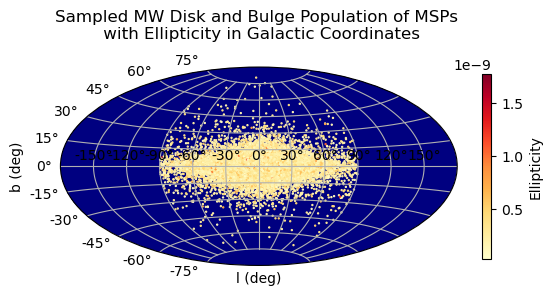

In [18]:
#try to do a 2D plot of the MW with sampled pulsars
import matplotlib.colors as colors
import matplotlib as mpl

#this is just for the nice blue background :)
q = np.ones([359, 129])
b = np.transpose(q)

fig = plt.figure()

#use aitoff projection to get the oval shape
ax = fig.add_subplot(111, projection='aitoff')
ra = np.linspace(-np.pi, np.pi, 360)
dec = np.linspace(-np.pi/2, np.pi/2, 130)
Ra, Dec = np.meshgrid(ra, dec)

cmap = plt.get_cmap('YlOrRd')
ep_rand_small = np.random.choice(epsilon_B, size = MSP_pop_small_size) #size = 40000
ep_rand = np.random.choice(epsilon_B, size = MSP_pop_size)

im = ax.pcolormesh(Ra, Dec, b, cmap=plt.cm.jet, norm=colors.LogNorm(vmax=z.max()))
sc = ax.scatter(init_phi_small, init_theta_small, c = ep_rand_small, s = 0.5, cmap = 'YlOrRd')

cb = plt.colorbar(sc, label = "Ellipticity", shrink = 0.5)
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs \n with Ellipticity in Galactic Coordinates", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

plt.show()

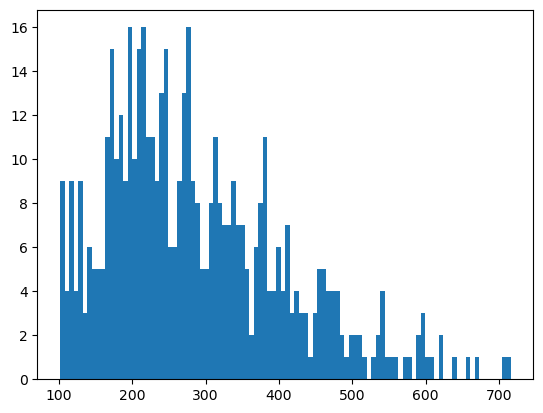

288.2443907316967
121.36792366842593


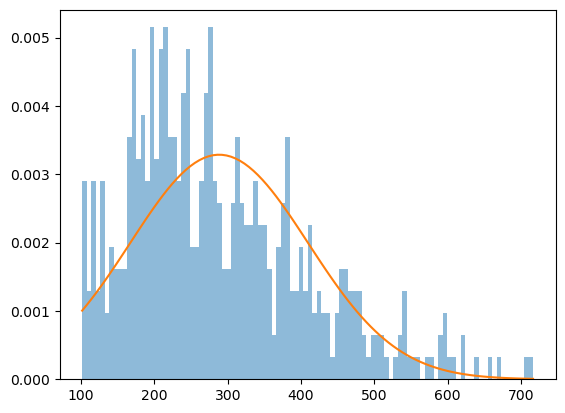

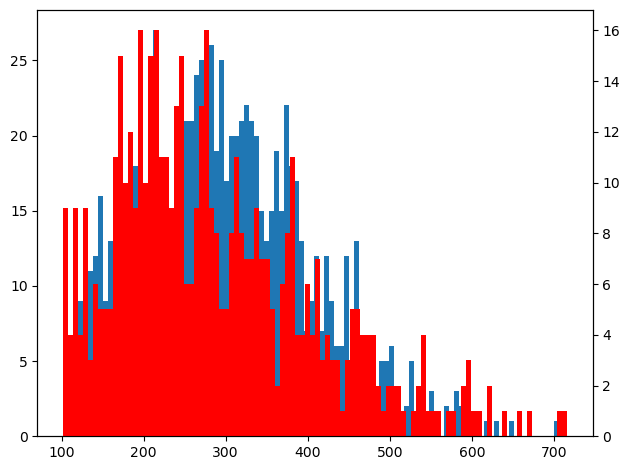

In [19]:
#to find the GW signal, we need to find the rotational frequency distribution
#need to query the ATNF database
from psrqpy import QueryATNF
import scipy
freq_query = QueryATNF(params=['F0'], condition = 'P0 < 0.01')

freq_df = freq_query.dataframe
freq_array = freq_df.to_numpy().flatten()[~np.isnan(freq_df.to_numpy().flatten())]
#print(freq_array.size) #is 855
#print(freq_array)

#frequency comes in 2 populations: high and low
high_freq_array = freq_array[freq_array > 100]

plt.hist(high_freq_array, 100)
plt.show()

#we only have 855 MSPs from the ATNF catalgoue with F0 data --> need to create a distribution
#look at just the high freq. array to begin b/c the low one is strange
_, bins, _ = plt.hist(high_freq_array, 100, density=1, alpha=0.5)
mu, sigma = scipy.stats.norm.fit(high_freq_array)

#find mu and sigma
print(mu)
print(sigma)

best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
plt.plot(bins, best_fit_line)
plt.show()

#create distribution
high_freq_dist = np.random.normal(mu, sigma, 1000)
fig, ax1 = plt.subplots()

ax1.hist(high_freq_dist[high_freq_dist > 100], bins = 100)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

#ax2.plot(best_fit_line, color = "red")
ax2.hist(high_freq_array, 100, color = "red")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

#now generate a sample of 40000
norm_freq_sample = np.random.normal(mu, sigma, 4000000)
freq_sample = np.random.choice(norm_freq_sample[norm_freq_sample >= 100], MSP_pop_size) #40000 as last number
freq_sample_small = np.random.choice(norm_freq_sample[norm_freq_sample >= 100], MSP_pop_small_size)

40000


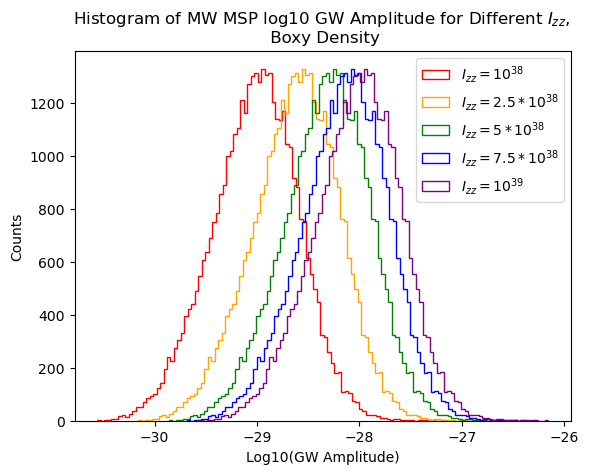

In [20]:
#the equation for the GW amplitude from Miller et al.:
#moment of inertia ranges from 10^38 to 10^39 kg m^2, choose 5 values
I_zz_1 = 10**38
I_zz_2 = 2.5*(10**38)
I_zz_3 = 5*(10**38)
I_zz_4 = 7.5*(10**38)
I_zz_5 = 10**39

init_A_GW_1 = (16*(math.pi**2)*(6.67e-11)*(I_zz_1)*ep_rand_small*(freq_sample_small**2))/(((3e8)**4)*dist_small*3.086e16)
init_A_GW_2 = (16*(math.pi**2)*(6.67e-11)*(I_zz_2)*ep_rand_small*(freq_sample_small**2))/(((3e8)**4)*dist_small*3.086e16)
init_A_GW_3 = (16*(math.pi**2)*(6.67e-11)*(I_zz_3)*ep_rand_small*(freq_sample_small**2))/(((3e8)**4)*dist_small*3.086e16)
init_A_GW_4 = (16*(math.pi**2)*(6.67e-11)*(I_zz_4)*ep_rand_small*(freq_sample_small**2))/(((3e8)**4)*dist_small*3.086e16)
init_A_GW_5 = (16*(math.pi**2)*(6.67e-11)*(I_zz_5)*ep_rand_small*(freq_sample_small**2))/(((3e8)**4)*dist_small*3.086e16)

A_GW_1 = init_A_GW_1[np.isfinite(init_A_GW_1)]
A_GW_2 = init_A_GW_2[np.isfinite(init_A_GW_2)]
A_GW_3 = init_A_GW_3[np.isfinite(init_A_GW_3)]
A_GW_4 = init_A_GW_4[np.isfinite(init_A_GW_4)]
A_GW_5 = init_A_GW_5[np.isfinite(init_A_GW_5)]

#to ensure that we still have a connection between dist. and GW amplitude
theta = init_theta_small[np.isfinite(init_A_GW_1)]
phi = init_phi_small[np.isfinite(init_A_GW_1)]

print(phi.size)

plt.hist(np.log10(A_GW_1), bins = 100, histtype = "step", color = "red", label = "$I_{zz} = 10^{38}$")
plt.hist(np.log10(A_GW_2), bins = 100, histtype = "step", color = "orange", label = "$I_{zz} = 2.5*10^{38}$")
plt.hist(np.log10(A_GW_3), bins = 100, histtype = "step", color = "green", label = "$I_{zz} = 5*10^{38}$")
plt.hist(np.log10(A_GW_4), bins = 100, histtype = "step", color = "blue", label = "$I_{zz} = 7.5*10^{38}$")
plt.hist(np.log10(A_GW_5), bins = 100, histtype = "step", color = "purple", label = "$I_{zz} = 10^{39}$")

plt.title("Histogram of MW MSP log10 GW Amplitude for Different $I_{zz}$, \n Boxy Density")
plt.ylabel("Counts")
plt.xlabel("Log10(GW Amplitude)")
plt.legend()
plt.show()

3.578324582459237e-23


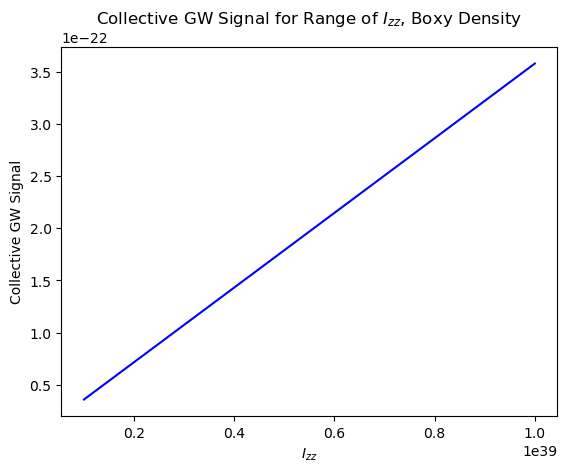

In [21]:
#now to find the collective GW signal
ep_rand_ang = np.random.choice(ep_rand_small, size = dist_ang_size)
freq_sample_ang = np.random.choice(freq_sample_small, size = dist_ang_size)

#first restrict A_GW to the population described by dist_ang
init_A_GW_ang = (16*(math.pi**2)*(6.67e-11)*(10**38)*ep_rand_ang*(freq_sample_ang**2))/(((3e8)**4)*dist_ang*3.086e16)

A_GW_ang = init_A_GW_ang[np.isfinite(init_A_GW_ang)]

collective_GW_sig = dist_ang_size*np.average(A_GW_ang)
print(collective_GW_sig)

#plot how the collective signal changes for a continuous distribution of I_zz
I_zz = np.linspace((10**38), (10**39), num = 10)
collective_A_GW_ang_plot = dist_ang_size*np.average((16*(math.pi**2)*(6.67e-11)*ep_rand_ang*(freq_sample_ang**2))/
                           (((3e8)**4)*dist_ang*3.086e16))*I_zz

plt.plot(I_zz, collective_A_GW_ang_plot, color = "blue")
plt.title("Collective GW Signal for Range of $I_{zz}$, Boxy Density")
plt.xlabel("$I_{zz}$")
plt.ylabel("Collective GW Signal")
plt.show()

#write to df
#import pandas as pd
#df_I_zz = pd.DataFrame(I_zz)
#df_coll_GW = pd.DataFrame(collective_A_GW_ang_plot)
#df_total = pd.concat([df_I_zz, df_coll_GW], axis = 1)
#df_total.to_csv("test_GW_line_2", index = False)

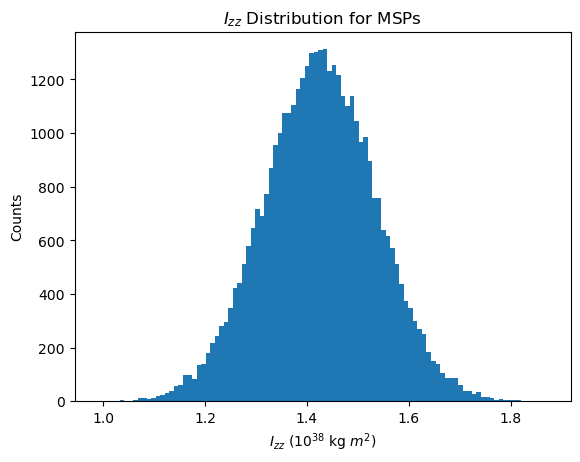

In [22]:
#create the I_zz distribution

#assuming a log normal distribution that follows the grey (all) distribution
#given in Lim et al. Fig. 7

I_zz_dist = np.random.normal(1.425, 0.1100, size = 4000000) #40,000
I_zz_dist_small = np.random.normal(1.425, 0.1100, size = 40000)
plt.hist(I_zz_dist_small, bins = 100)

plt.title("$I_{zz}$ Distribution for MSPs")
plt.xlabel("$I_{zz}$ ($10^{38}$ kg $m^2$)")
plt.ylabel("Counts")
plt.show()

#this seems to be within the range given by Worley et al. for the
#I_zz vs. freq. distribution for some of the models used

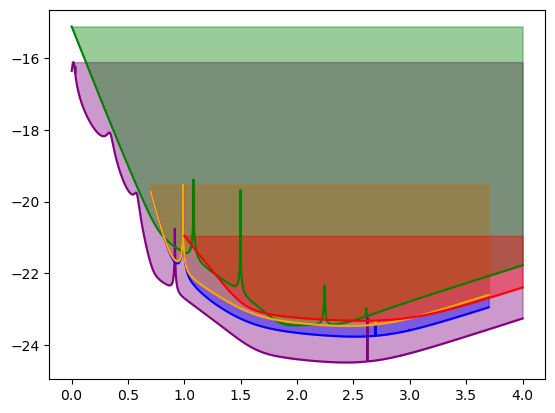

In [23]:
#turns out they have the GW detector sensitivity curve data free for people to download, so

#read in the ET, etc. sensitivity curve for plotting below
# first column is freq., 3rd is GW signal for ET

ET_sensitivity_freq = np.loadtxt("ET-0000A-18_ETDSensitivityCurveTxtFile.txt", usecols = (0))
ET_sensitivity_GW = np.loadtxt("ET-0000A-18_ETDSensitivityCurveTxtFile.txt", usecols = (2))
AligoP_sens_freq = np.loadtxt("AplusDesign.txt", usecols = (0))
AligoP_sense_GW = np.loadtxt("AplusDesign.txt", usecols = (1))
kagra_sen_freq = np.loadtxt("bKAGRA.txt", usecols = (0))
kagra_sen_GW = np.loadtxt("bKAGRA.txt", usecols = (1))
Aligo_sen_freq = np.loadtxt("aLIGO.txt", usecols = (0))
Aligo_sen_GW = np.loadtxt("aLIGO.txt", usecols = (1))
Avirgo_sen_freq = np.loadtxt("AdV.txt", usecols = (0))
Avirgo_sen_GW = np.loadtxt("AdV.txt", usecols = (1))


fig, ax = plt.subplots()
ax.plot(np.log10(ET_sensitivity_freq), np.log10(ET_sensitivity_GW), color = "purple")
ax.plot(np.log10(AligoP_sens_freq), np.log10(AligoP_sense_GW), color = "blue")
ax.plot(np.log10(kagra_sen_freq), np.log10(kagra_sen_GW), color = "green")
ax.plot(np.log10(Aligo_sen_freq), np.log10(Aligo_sen_GW), color = "orange")
ax.plot(np.log10(Avirgo_sen_freq), np.log10(Avirgo_sen_GW), color = "red")


ax.fill_between(np.log10(ET_sensitivity_freq), np.log10(ET_sensitivity_GW).max(), 
                np.log10(ET_sensitivity_GW), alpha = 0.4, color = "purple")
ax.fill_between(np.log10(AligoP_sens_freq), np.log10(AligoP_sense_GW).max(), 
                np.log10(AligoP_sense_GW), alpha = 0.4, color = "blue")
ax.fill_between(np.log10(kagra_sen_freq), np.log10(kagra_sen_GW).max(), 
                np.log10(kagra_sen_GW), alpha = 0.4, color = "green")
ax.fill_between(np.log10(Aligo_sen_freq), np.log10(Aligo_sen_GW).max(), 
                np.log10(Aligo_sen_GW), alpha = 0.4, color = "orange")
ax.fill_between(np.log10(Avirgo_sen_freq), np.log10(Avirgo_sen_GW).max(), 
                np.log10(Avirgo_sen_GW), alpha = 0.4, color = "red")
plt.show()

2.723084790926365


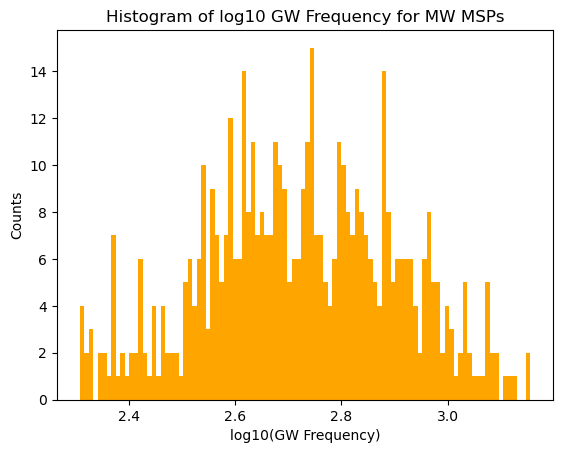

2.723084790926365
0.1825273530723286


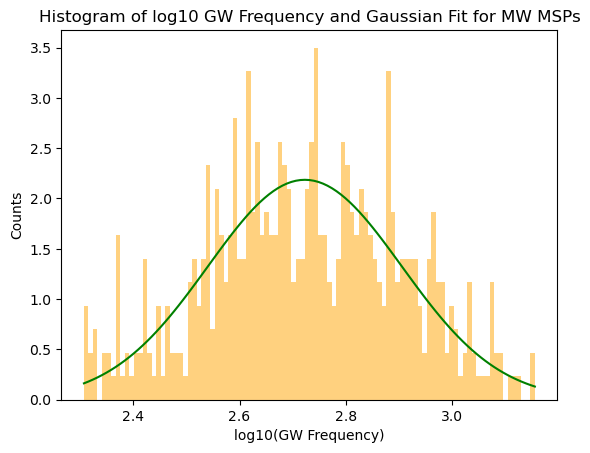

In [24]:
#plot the GW frequency distribution

#from Miller et al.: f_GW = 2f_rot
f_GW = 2*high_freq_array
print(np.average(np.log10(f_GW)))

#plot all distributions
plt.hist(np.log10(f_GW), bins = 100, color = "orange")
plt.title("Histogram of log10 GW Frequency for MW MSPs")
plt.ylabel("Counts")
plt.xlabel("log10(GW Frequency)")
plt.show()

_, bins, _ = plt.hist(np.log10(f_GW), 100, density=1, alpha=0.5, color = "orange")
mu_GW, sigma_GW = scipy.stats.norm.fit(np.log10(f_GW))

#find mu and sigma
print(mu_GW)
print(sigma_GW)

f_GW_best_fit_line = scipy.stats.norm.pdf(bins, mu_GW, sigma_GW)
plt.plot(bins, f_GW_best_fit_line, color = "green")
plt.title("Histogram of log10 GW Frequency and Gaussian Fit for MW MSPs")
plt.ylabel("Counts")
plt.xlabel("log10(GW Frequency)")
plt.show()

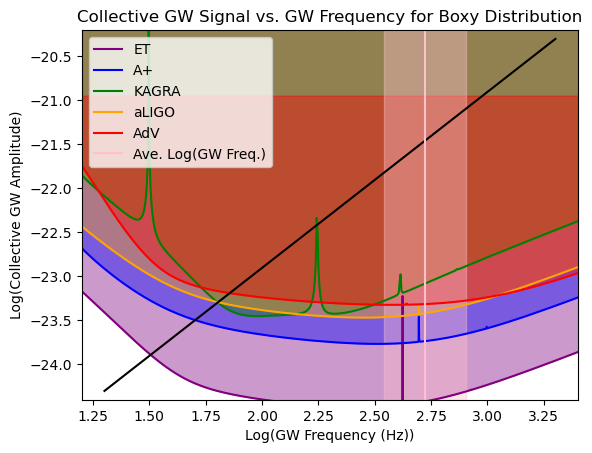

In [25]:
#find the spectrum of the collective GW signal compared to a range of GW frequencies
I_zz_spectrum = np.random.choice(I_zz_dist_small, size = dist_ang_size)
freq_range = np.linspace(10, 1000, 1000)

collective_A_GW_ang_spectrum = dist_ang_size*(np.average((16*(math.pi**2)*(6.67e-11)*(I_zz_spectrum*10e38)*ep_rand_ang)
                                                        /(((3e8)**4)*dist_ang*3.086e16)))*((freq_range**2))

fig, ax = plt.subplots()
#plot sensitivity curves for ET, aLIGO A+, KAGRA, aLIGO, AdV:
ax.plot(np.log10(ET_sensitivity_freq), np.log10(ET_sensitivity_GW), color = "purple", label = "ET")
ax.plot(np.log10(AligoP_sens_freq), np.log10(AligoP_sense_GW), color = "blue", label = "A+")
ax.plot(np.log10(kagra_sen_freq), np.log10(kagra_sen_GW), color = "green", label = "KAGRA")
ax.plot(np.log10(Aligo_sen_freq), np.log10(Aligo_sen_GW), color = "orange", label = "aLIGO")
ax.plot(np.log10(Avirgo_sen_freq), np.log10(Avirgo_sen_GW), color = "red", label = "AdV")


ax.fill_between(np.log10(ET_sensitivity_freq), np.log10(ET_sensitivity_GW).max(), 
                np.log10(ET_sensitivity_GW), alpha = 0.4, color = "purple")
ax.fill_between(np.log10(AligoP_sens_freq), np.log10(AligoP_sense_GW).max(), 
                np.log10(AligoP_sense_GW), alpha = 0.4, color = "blue")
ax.fill_between(np.log10(kagra_sen_freq), np.log10(kagra_sen_GW).max(), 
                np.log10(kagra_sen_GW), alpha = 0.4, color = "green")
ax.fill_between(np.log10(Aligo_sen_freq), np.log10(Aligo_sen_GW).max(), 
                np.log10(Aligo_sen_GW), alpha = 0.4, color = "orange")
ax.fill_between(np.log10(Avirgo_sen_freq), np.log10(Avirgo_sen_GW).max(), 
                np.log10(Avirgo_sen_GW), alpha = 0.4, color = "red")

#plot the collective signal
plt.plot(np.log10(2*freq_range), np.log10(collective_A_GW_ang_spectrum), color = "black")
plt.title("Collective GW Signal vs. GW Frequency for Boxy Distribution")
plt.xlabel("Log(GW Frequency (Hz))")
plt.ylabel("Log(Collective GW Amplitude)")

#plot the ave. GW freq. for the population of ATNF MSPs and 1 sigma width
plt.axvline(x = mu_GW, color = 'pink', label = 'Ave. Log(GW Freq.)')
ax.axvspan(mu_GW - sigma_GW, mu_GW + sigma_GW, alpha=0.4, color='pink')

plt.xlim(np.log10(2*freq_range).min() - 0.1, np.log10(2*freq_range).max() + 0.1)
plt.ylim(np.log10(collective_A_GW_ang_spectrum).min() - 0.1, np.log10(collective_A_GW_ang_spectrum).max() + 0.1)
plt.legend()
plt.show()

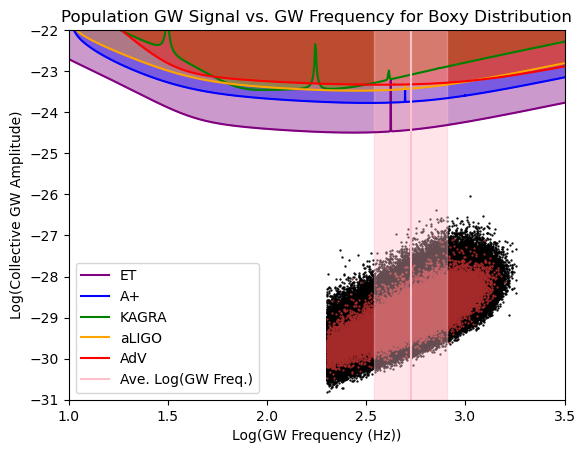

In [27]:
#plot the entire population on the GW freq. vs. GW signal plot
#find the spectrum of the collective GW signal compared to a range of GW frequencies
I_zz_spectrum_1 = np.random.choice(I_zz_dist_small, size = MSP_pop_small_size)
I_zz_spectrum_2 = np.random.choice(I_zz_dist, size = MSP_pop_size)

A_GW_pop_small = (16*(math.pi**2)*(6.67e-11)*(I_zz_spectrum_1*(10**38))*ep_rand_small*(freq_sample_small**2))/(((3e8)**4)*dist_small*3.086e16)
A_GW_pop = (16*(math.pi**2)*(6.67e-11)*(I_zz_spectrum_2*(10**38))*ep_rand*(freq_sample**2))/(((3e8)**4)*dist*3.086e16)

fig, ax = plt.subplots()
#plot sensitivity curves for ET, aLIGO A+, KAGRA, aLIGO, AdV:
ax.plot(np.log10(ET_sensitivity_freq), np.log10(ET_sensitivity_GW), color = "purple", label = "ET")
ax.plot(np.log10(AligoP_sens_freq), np.log10(AligoP_sense_GW), color = "blue", label = "A+")
ax.plot(np.log10(kagra_sen_freq), np.log10(kagra_sen_GW), color = "green", label = "KAGRA")
ax.plot(np.log10(Aligo_sen_freq), np.log10(Aligo_sen_GW), color = "orange", label = "aLIGO")
ax.plot(np.log10(Avirgo_sen_freq), np.log10(Avirgo_sen_GW), color = "red", label = "AdV")


ax.fill_between(np.log10(ET_sensitivity_freq), np.log10(ET_sensitivity_GW).max(), 
                np.log10(ET_sensitivity_GW), alpha = 0.4, color = "purple")
ax.fill_between(np.log10(AligoP_sens_freq), np.log10(AligoP_sense_GW).max(), 
                np.log10(AligoP_sense_GW), alpha = 0.4, color = "blue")
ax.fill_between(np.log10(kagra_sen_freq), np.log10(kagra_sen_GW).max(), 
                np.log10(kagra_sen_GW), alpha = 0.4, color = "green")
ax.fill_between(np.log10(Aligo_sen_freq), np.log10(Aligo_sen_GW).max(), 
                np.log10(Aligo_sen_GW), alpha = 0.4, color = "orange")
ax.fill_between(np.log10(Avirgo_sen_freq), np.log10(Avirgo_sen_GW).max(), 
                np.log10(Avirgo_sen_GW), alpha = 0.4, color = "red")

#plot the population's signal
plt.scatter(np.log10(2*freq_sample), np.log10(A_GW_pop.astype(float)), color = "black", s = 0.4)
plt.scatter(np.log10(2*freq_sample_small), np.log10(A_GW_pop_small.astype(float)), color = "brown", s = 0.4)
plt.title("Population GW Signal vs. GW Frequency for Boxy Distribution")
plt.xlabel("Log(GW Frequency (Hz))")
plt.ylabel("Log(Collective GW Amplitude)")

#plot the ave. GW freq. for the population of ATNF MSPs and 1 sigma width
plt.axvline(x = mu_GW, color = 'pink', label = 'Ave. Log(GW Freq.)')
ax.axvspan(mu_GW - sigma_GW, mu_GW + sigma_GW, alpha=0.4, color='pink')

plt.xlim(1, 3.5)
plt.ylim(-31, -22)
plt.legend()
plt.show()

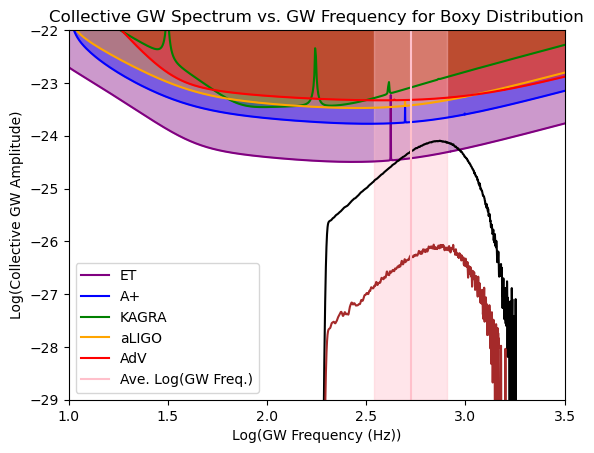

In [29]:
#collective signal take 2: gaussian addition approach

#need to plot each A_GW point as a gaussian instead of a point, then add

#define Gaussian curve
def Gaussian_GW_signal(a, b, c, x):
    return a*np.exp(-((x - b)**2)/(2*(c**2)))

#add Gaussian curves together
def sum_Gaussian_GW_signal(a, b, c, x):
    arr_i = np.zeros(x.size)
    for i in range(a.size):
        arr_i = arr_i + Gaussian_GW_signal(a[i], b[i], c, x)
        
    return arr_i

#find GW signal for a range of I_zz for entire population
I_zz_ind_sample = np.random.choice(I_zz_dist, size = 4000000)*(10**38)
I_zz_ind_sample_small = np.random.choice(I_zz_dist, size = 40000)*(10**38)
A_GW_ind = (16*(math.pi**2)*(6.67e-11)*(I_zz_ind_sample)*ep_rand*(freq_sample**2))/(((3e8)**4)*dist*3.086e16)
A_GW_ind_small = (16*(math.pi**2)*(6.67e-11)*(I_zz_ind_sample_small)*ep_rand_small*(freq_sample_small**2))/(((3e8)**4)*dist_small*3.086e16)

#define parameters: a = A_GW, b = GW freq.
x = np.linspace(freq_sample.min() - 10, freq_sample.max() + 10, 5000) #frequency range to plot over
x_2 = np.linspace(freq_sample_small.min() - 10, freq_sample_small.max() + 10, 5000)
a = A_GW_ind #GW signal for each MSP
a_2 = A_GW_ind_small
b = freq_sample #GQ freq. for each MSP
b_2 = freq_sample_small
c = 1

A_GW_coll_signal = sum_Gaussian_GW_signal(a, b, c, x)
A_GW_coll_signal_small = sum_Gaussian_GW_signal(a_2, b_2, c, x_2)

fig, ax = plt.subplots()
#plot sensitivity curves for ET, aLIGO A+, KAGRA, aLIGO, AdV:
ax.plot(np.log10(ET_sensitivity_freq), np.log10(ET_sensitivity_GW), color = "purple", label = "ET")
ax.plot(np.log10(AligoP_sens_freq), np.log10(AligoP_sense_GW), color = "blue", label = "A+")
ax.plot(np.log10(kagra_sen_freq), np.log10(kagra_sen_GW), color = "green", label = "KAGRA")
ax.plot(np.log10(Aligo_sen_freq), np.log10(Aligo_sen_GW), color = "orange", label = "aLIGO")
ax.plot(np.log10(Avirgo_sen_freq), np.log10(Avirgo_sen_GW), color = "red", label = "AdV")


ax.fill_between(np.log10(ET_sensitivity_freq), np.log10(ET_sensitivity_GW).max(), 
                np.log10(ET_sensitivity_GW), alpha = 0.4, color = "purple")
ax.fill_between(np.log10(AligoP_sens_freq), np.log10(AligoP_sense_GW).max(), 
                np.log10(AligoP_sense_GW), alpha = 0.4, color = "blue")
ax.fill_between(np.log10(kagra_sen_freq), np.log10(kagra_sen_GW).max(), 
                np.log10(kagra_sen_GW), alpha = 0.4, color = "green")
ax.fill_between(np.log10(Aligo_sen_freq), np.log10(Aligo_sen_GW).max(), 
                np.log10(Aligo_sen_GW), alpha = 0.4, color = "orange")
ax.fill_between(np.log10(Avirgo_sen_freq), np.log10(Avirgo_sen_GW).max(), 
                np.log10(Avirgo_sen_GW), alpha = 0.4, color = "red")

plt.plot(np.log10(2*x), np.log10(A_GW_coll_signal), color = "black")
plt.plot(np.log10(2*x_2), np.log10(A_GW_coll_signal_small), color = "brown")
plt.title("Collective GW Spectrum vs. GW Frequency for Boxy Distribution")
plt.xlabel("Log(GW Frequency (Hz))")
plt.ylabel("Log(Collective GW Amplitude)")

#plot the ave. GW freq. for the population of ATNF MSPs and 1 sigma width
plt.axvline(x = mu_GW, color = 'pink', label = 'Ave. Log(GW Freq.)')
ax.axvspan(mu_GW - sigma_GW, mu_GW + sigma_GW, alpha=0.4, color='pink')

#plt.xlim(np.log10(2*freq_spect_sample).min() - 0.1, np.log10(2*freq_spect_sample).max() + 0.1)
#plt.ylim(np.log10(A_GW_ind.astype("float")).min() - 0.1, np.log10(A_GW_ind.astype("float")).max() + 0.1)
plt.xlim(1, 3.5)
plt.ylim(-29, -22)
plt.legend()
plt.show()

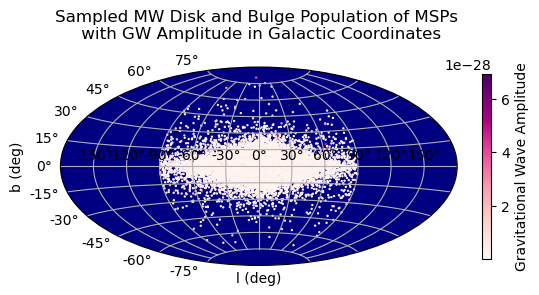

In [30]:
#make a similar 2D plot as the ellipticity one but with the GW amplitude instead
#try to do a 2D plot of the MW with sampled pulsars
import matplotlib.colors as colors
import matplotlib as mpl

#this is just for the nice blue background :)
a = np.ones([359, 129])
b = np.transpose(a)

fig = plt.figure()

#use aitoff projection to get the oval shape
ax = fig.add_subplot(111, projection='aitoff')
ra = np.linspace(-np.pi, np.pi, 360)
dec = np.linspace(-np.pi/2, np.pi/2, 130)
Ra, Dec = np.meshgrid(ra, dec)

cmap = plt.get_cmap('RdPu')

im = ax.pcolormesh(Ra, Dec, b, cmap=plt.cm.jet, norm=colors.LogNorm(vmax=z.max()))
sc = ax.scatter(phi, theta, c = A_GW_1, s = 0.5, cmap = 'RdPu')

cb = plt.colorbar(sc, label = "Gravitational Wave Amplitude", shrink = 0.5)
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs \n with GW Amplitude in Galactic Coordinates", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

plt.show()

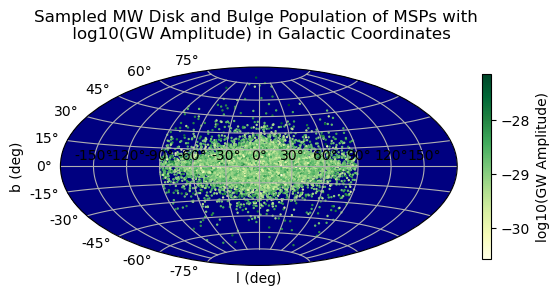

In [31]:
#make a similar 2D plot as the ellipticity one but with the GW amplitude instead (log scale version)
#try to do a 2D plot of the MW with sampled pulsars
import matplotlib.colors as colors
import matplotlib as mpl

#this is just for the nice blue background :)
a = np.ones([359, 129])
b = np.transpose(a)

fig = plt.figure()

#use aitoff projection to get the oval shape
ax = fig.add_subplot(111, projection='aitoff')
ra = np.linspace(-np.pi, np.pi, 360)
dec = np.linspace(-np.pi/2, np.pi/2, 130)
Ra, Dec = np.meshgrid(ra, dec)

cmap = plt.get_cmap('RdPu')

im = ax.pcolormesh(Ra, Dec, b, cmap=plt.cm.jet, norm=colors.LogNorm(vmax=z.max()))
sc = ax.scatter(phi, theta, c = np.log10(A_GW_1), s = 0.5, cmap = 'YlGn')

cb = plt.colorbar(sc, label = "log10(GW Amplitude)", shrink = 0.5)
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs with \n log10(GW Amplitude) in Galactic Coordinates", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

plt.show()

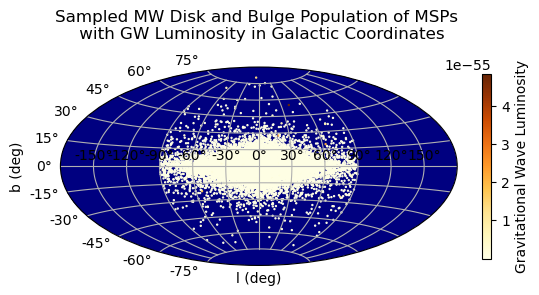

In [32]:
#make a similar 2D plot as the ellipticity one but with the GW luminosity instead
#try to do a 2D plot of the MW with sampled pulsars
import matplotlib.colors as colors
import matplotlib as mpl

#this is just for the nice blue background :)
a = np.ones([359, 129])
b = np.transpose(a)

fig = plt.figure()

#use aitoff projection to get the oval shape
ax = fig.add_subplot(111, projection='aitoff')
ra = np.linspace(-np.pi, np.pi, 360)
dec = np.linspace(-np.pi/2, np.pi/2, 130)
Ra, Dec = np.meshgrid(ra, dec)

cmap = plt.get_cmap('RdPu')

im = ax.pcolormesh(Ra, Dec, b, cmap=plt.cm.jet, norm=colors.LogNorm(vmax=z.max()))
sc = ax.scatter(phi, theta, c = A_GW_1**2, s = 0.5, cmap = 'YlOrBr')

cb = plt.colorbar(sc, label = "Gravitational Wave Luminosity", shrink = 0.5)
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs \n with GW Luminosity in Galactic Coordinates", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

plt.show()

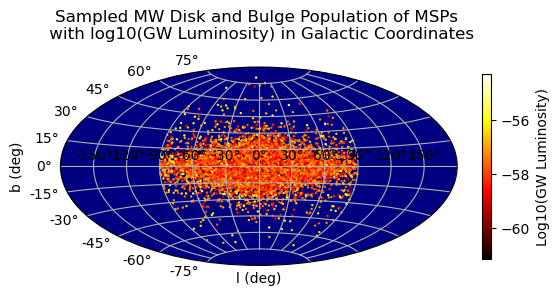

In [33]:
#make a similar 2D plot as the ellipticity one but with the log 10 GW luminosity instead
#try to do a 2D plot of the MW with sampled pulsars
import matplotlib.colors as colors
import matplotlib as mpl

#this is just for the nice blue background :)
a = np.ones([359, 129])
b = np.transpose(a)

fig = plt.figure()

#use aitoff projection to get the oval shape
ax = fig.add_subplot(111, projection='aitoff')
ra = np.linspace(-np.pi, np.pi, 360)
dec = np.linspace(-np.pi/2, np.pi/2, 130)
Ra, Dec = np.meshgrid(ra, dec)

cmap = plt.get_cmap('RdPu')

im = ax.pcolormesh(Ra, Dec, b, cmap=plt.cm.jet, norm=colors.LogNorm(vmax=z.max()))
sc = ax.scatter(phi, theta, c = np.log10(A_GW_1**2), s = 0.5, cmap = 'hot')

cb = plt.colorbar(sc, label = "Log10(GW Luminosity)", shrink = 0.5)
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs \n with log10(GW Luminosity) in Galactic Coordinates", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

plt.show()

-61.11596690920945


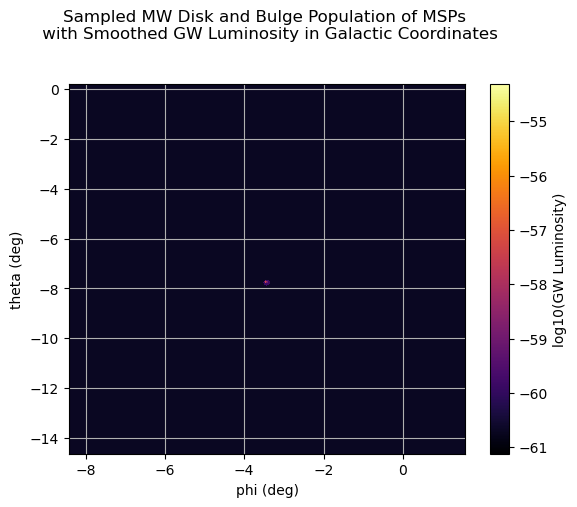

In [34]:
#smooth out GW luminosity values with a Gaussian distribution related to angular resolution
#the rectangular version, just to check things
from scipy.ndimage import gaussian_filter

print(np.min(np.log10(A_GW_1**2)))

#assuming that the angular resolution is 1 arcminute (width of gaussian is 0.01667 deg/2.91E-4 rad)
data1 = np.histogram2d(phi, theta, bins=130, weights = np.log10(A_GW_1**2))[0]
data2 = gaussian_filter(data1, sigma=0.01667)

plt.contourf(data2.T, cmap='inferno_r', extent = ((180/math.pi)*phi[0], (180/math.pi)*phi[-1], (180/math.pi)*theta[0], (180/math.pi)*theta[-1]))

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(np.min(np.log10((A_GW_1)**2)), 
       np.max(np.log10((A_GW_1)**2))), cmap='inferno'), label = "log10(GW Luminosity)")


#plt.colorbar(label = "GW Luminosity")
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs \n with Smoothed GW Luminosity in Galactic Coordinates", y = 1.1)
plt.xlabel("phi (deg)")
plt.ylabel("theta (deg)")

plt.show()

<Figure size 640x480 with 0 Axes>

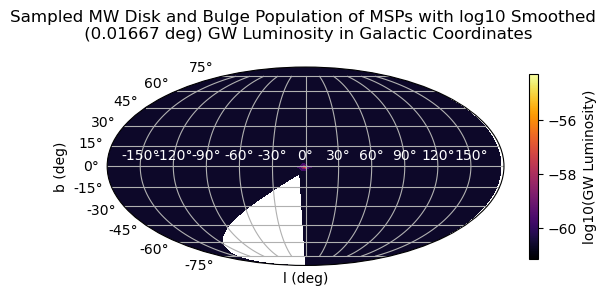

[]


ValueError: zero-size array to reduction operation minimum which has no identity

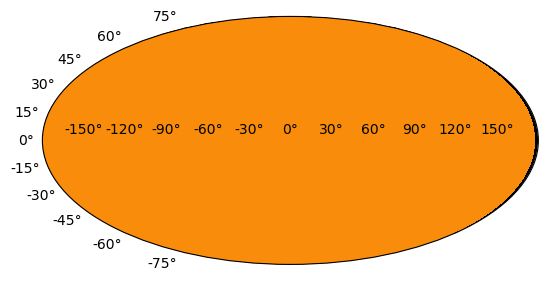

In [35]:
#smooth out GW luminosity values with a Gaussian distribution related to angular resolution
#the mollweide projection one!
from scipy.ndimage import gaussian_filter
import matplotlib as mpl

fig = plt.figure()

bin_number = 130
lon_edges = np.linspace(-np.pi, np.pi, bin_number + 1)
lat_edges = np.linspace(-np.pi/2., np.pi/2., bin_number + 1)

#plot with no sensitivity
data1 = np.histogram2d(phi, theta, bins=[lon_edges, lat_edges], weights = np.log10((A_GW_1**2)))[0]
#assuming that the angular resolution is 1 arcminute (width of gaussian is 0.01667 deg/2.91E-4 rad)
data2 = gaussian_filter(data1, sigma=0.01667) 

#use mollweide projection b/c aitoff is messed up (though that might just be the bounds)
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')

cf = ax.contourf(lon_edges[:-1], lat_edges[:-1], data2.T, cmap='inferno_r')

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(np.min(np.log10((A_GW_1)**2)), 
       np.max(np.log10((A_GW_1)**2))), cmap='inferno'), shrink = 0.5,label = "log10(GW Luminosity)")
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs with log10 Smoothed \n (0.01667 deg) GW Luminosity in Galactic Coordinates", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

#mpl.rcParams['axes.labelcolor'] = 'black'
plt.xticks(color = "white")

plt.show()

#most conservative sensitivity (GEO)
A_GW_cons = A_GW_1[A_GW_1 > 3e-23]
print(A_GW_cons)

data1 = np.histogram2d(phi[A_GW_1 > 3e-23], theta[A_GW_1 > 3e-23], bins=[lon_edges, lat_edges], weights = np.log10((A_GW_cons**2)))[0]
#assuming that the angular resolution is 1 arcminute (width of gaussian is 0.01667 deg/2.91E-4 rad)
data2 = gaussian_filter(data1, sigma=0.01667) 

#use mollweide projection b/c aitoff is messed up (though that might just be the bounds)
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')

im = ax.pcolormesh(Ra, Dec, b, cmap=plt.cm.inferno, norm=colors.LogNorm(vmax=z.max()))
cf = ax.contourf(lon_edges[:-1], lat_edges[:-1], data2.T, cmap='inferno_r')

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(np.min(np.log10((A_GW_cons)**2)), 
       np.max(np.log10((A_GW_cons)**2))), cmap='inferno'), shrink = 0.5,label = "log10(GW Luminosity)")
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs with log10 Smoothed \n (0.01667 deg) GW Luminosity in Galactic Coordinates (conservative)", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

#mpl.rcParams['axes.labelcolor'] = 'white'
plt.xticks(color = "white")

plt.show()

#second plot with best sensitivity (ET)
A_GW_opt = A_GW_1[A_GW_1 > 1e-24]
print(A_GW_opt.size)

data1 = np.histogram2d(phi[A_GW_1 > 1e-24], theta[A_GW_1 > 1e-24], bins=[lon_edges, lat_edges], weights = np.log10((A_GW_opt)**2))[0]
#assuming that the angular resolution is 1 arcminute (width of gaussian is 0.01667 deg/2.91E-4 rad)
data2 = gaussian_filter(data1, sigma=0.01667) 

#use mollweide projection b/c aitoff is messed up (though that might just be the bounds)
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')

im = ax.pcolormesh(Ra, Dec, b, cmap=plt.cm.inferno, norm=colors.LogNorm(vmax=z.max()))
cf = ax.contourf(lon_edges[:-1], lat_edges[:-1], data2.T, cmap='inferno_r')

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(np.min(np.log10((A_GW_opt)**2)), 
       np.max(np.log10((A_GW_opt)**2))), cmap='inferno'), shrink = 0.5,label = "log10(GW Luminosity)")
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs with log10 \n Smoothed (0.01667 deg) GW Luminosity in Galactic Coordinates (best)", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

#mpl.rcParams['axes.labelcolor'] = 'black'
plt.xticks(color = "white")

plt.show()

In [ ]:
#smooth out GW luminosity values with a Gaussian distribution related to angular resolution
#the mollweide projection one!
from scipy.ndimage import gaussian_filter
import matplotlib as mpl

fig = plt.figure()

bin_number = 130
lon_edges = np.linspace(-np.pi, np.pi, bin_number + 1)
lat_edges = np.linspace(-np.pi/2., np.pi/2., bin_number + 1)

#plot with no sensitivity
data1 = np.histogram2d(phi, theta, bins=[lon_edges, lat_edges], weights = np.log10((A_GW_1**2)))[0]
#assuming that the angular resolution is 10 arcminutes 
data2 = gaussian_filter(data1, sigma=0.1667) 

#use mollweide projection b/c aitoff is messed up (though that might just be the bounds)
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')

cf = ax.contourf(lon_edges[:-1], lat_edges[:-1], data2.T, cmap='inferno_r')

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(np.min(np.log10((A_GW_1)**2)), 
       np.max(np.log10((A_GW_1)**2))), cmap='inferno'), shrink = 0.5,label = "log10(GW Luminosity)")
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs with log10 Smoothed \n (0.1667 deg) GW Luminosity in Galactic Coordinates", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

#mpl.rcParams['axes.labelcolor'] = 'black'
plt.xticks(color = "white")

plt.show()

#most conservative sensitivity (GEO)
data1 = np.histogram2d(phi[A_GW_1 > 3e-23], theta[A_GW_1 > 3e-23], bins=[lon_edges, lat_edges], weights = np.log10((A_GW_cons)**2))[0]
#assuming that the angular resolution is 10 arcminutes
data2 = gaussian_filter(data1, sigma=0.1667) 

#use mollweide projection b/c aitoff is messed up (though that might just be the bounds)
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')

im = ax.pcolormesh(Ra, Dec, b, cmap=plt.cm.inferno, norm=colors.LogNorm(vmax=z.max()))
cf = ax.contourf(lon_edges[:-1], lat_edges[:-1], data2.T, cmap='inferno_r')

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(np.min(np.log10((A_GW_cons)**2)), 
       np.max(np.log10((A_GW_cons)**2))), cmap='inferno'), shrink = 0.5,label = "log10(GW Luminosity)")
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs with log10 Smoothed \n (0.1667 deg) GW Luminosity in Galactic Coordinates (conservative)", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

#mpl.rcParams['axes.labelcolor'] = 'black'
plt.xticks(color = "white")

plt.show()

#second plot with best sensitivity (ET)
data1 = np.histogram2d(phi[A_GW_1 > 1e-24], theta[A_GW_1 > 1e-24], bins=[lon_edges, lat_edges], weights = np.log10((A_GW_opt)**2))[0]
#assuming that the angular resolution is 10 arcminutes
data2 = gaussian_filter(data1, sigma=0.1667) 

#use mollweide projection b/c aitoff is messed up (though that might just be the bounds)
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')

im = ax.pcolormesh(Ra, Dec, b, cmap=plt.cm.inferno, norm=colors.LogNorm(vmax=z.max()))
cf = ax.contourf(lon_edges[:-1], lat_edges[:-1], data2.T, cmap='inferno_r')

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(np.min(np.log10((A_GW_opt)**2)), 
       np.max(np.log10((A_GW_opt)**2))), cmap='inferno'), shrink = 0.5,label = "log10(GW Luminosity)")
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs with log10 \n Smoothed (0.1667 deg) GW Luminosity in Galactic Coordinates (best)", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

#mpl.rcParams['axes.labelcolor'] = 'black'
plt.xticks(color = "white")

plt.show()

In [ ]:
#smooth out GW luminosity values with a Gaussian distribution related to angular resolution
#the mollweide projection one!
from scipy.ndimage import gaussian_filter
import matplotlib as mpl

fig = plt.figure()

bin_number = 130
lon_edges = np.linspace(-np.pi, np.pi, bin_number + 1)
lat_edges = np.linspace(-np.pi/2., np.pi/2., bin_number + 1)

#plot with no sensitivity
data1 = np.histogram2d(phi, theta, bins=[lon_edges, lat_edges], weights = np.log10((A_GW_1**2)))[0]
#assuming that the angular resolution is 3 deg
data2 = gaussian_filter(data1, sigma=3) 

#use mollweide projection b/c aitoff is messed up (though that might just be the bounds)
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')

im = ax.pcolormesh(Ra, Dec, b, color = "#3a0000")
#im = ax.pcolormesh(Ra, Dec, b, cmap=plt.cm.hot, norm=colors.LogNorm(vmax=z.max()))
cf = ax.contourf(lon_edges[:-1], lat_edges[:-1], data2.T, cmap='hot_r')

print(np.min(np.log10((A_GW_1)**2)))
print(np.max(np.log10((A_GW_1)**2)))

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(np.min(np.log10((A_GW_1)**2)), 
       np.max(np.log10((A_GW_1)**2))), cmap='hot'), shrink = 0.5,label = "log10(GW Luminosity)")
plt.grid()

plt.title("Sampled MW Boxy Population of MSPs with log10 Smoothed \n (3 deg) GW Luminosity in Galactic Coordinates", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

#mpl.rcParams['axes.labelcolor'] = 'black'
plt.xticks(color = "white")

plt.show()

#most conservative sensitivity (GEO)
data1 = np.histogram2d(phi[A_GW_1 > 3e-23], theta[A_GW_1 > 3e-23], bins=[lon_edges, lat_edges], weights = np.log10((A_GW_cons)**2))[0]
#assuming that the angular resolution is 1.7 deg
data2 = gaussian_filter(data1, sigma=1.7) 

#use mollweide projection b/c aitoff is messed up (though that might just be the bounds)
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')

print(z.max())

im = ax.pcolormesh(Ra, Dec, b, cmap=plt.cm.inferno, norm=colors.LogNorm(vmax=z.max()))
cf = ax.contourf(lon_edges[:-1], lat_edges[:-1], data2.T, cmap='inferno_r')

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(np.min(np.log10((A_GW_cons)**2)), 
       np.max(np.log10((A_GW_cons)**2))), cmap='inferno'), shrink = 0.5,label = "log10(GW Luminosity)")
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs with log10 Smoothed \n (1.7 deg) GW Luminosity in Galactic Coordinates (conservative)", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

#mpl.rcParams['axes.labelcolor'] = 'black'
plt.xticks(color = "white")

plt.show()

#second plot with best sensitivity (ET)
data1 = np.histogram2d(phi[A_GW_1 > 1e-24], theta[A_GW_1 > 1e-24], bins=[lon_edges, lat_edges], weights = np.log10((A_GW_opt)**2))[0]
#assuming that the angular resolution is 1.7 deg
data2 = gaussian_filter(data1, sigma=1.7) 

#use mollweide projection b/c aitoff is messed up (though that might just be the bounds)
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')

im = ax.pcolormesh(Ra, Dec, b, cmap=plt.cm.inferno, norm=colors.LogNorm(vmax=z.max()))
cf = ax.contourf(lon_edges[:-1], lat_edges[:-1], data2.T, cmap='inferno_r')

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(np.min(np.log10((A_GW_opt)**2)), 
       np.max(np.log10((A_GW_opt)**2))), cmap='inferno'), shrink = 0.5,label = "log10(GW Luminosity)")
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs with log10 \n Smoothed (1.7 deg) GW Luminosity in Galactic Coordinates (best)", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

#mpl.rcParams['axes.labelcolor'] = 'black'
plt.xticks(color = "white")

plt.show()

In [ ]:
#smooth out GW luminosity values with a Gaussian distribution related to angular resolution
#the mollweide projection one!
from scipy.ndimage import gaussian_filter
import matplotlib as mpl

fig = plt.figure()

bin_number = 130
lon_edges = np.linspace(-np.pi, np.pi, bin_number + 1)
lat_edges = np.linspace(-np.pi/2., np.pi/2., bin_number + 1)

#plot with no sensitivity
data1 = np.histogram2d(phi, theta, bins=[lon_edges, lat_edges], weights = np.log10((A_GW_1**2)))[0]
#assuming that the angular resolution is 10 deg
data2 = gaussian_filter(data1, sigma=10) 

#use mollweide projection b/c aitoff is messed up (though that might just be the bounds)
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')

im = ax.pcolormesh(Ra, Dec, b, cmap=plt.cm.inferno, norm=colors.LogNorm(vmax=z.max()))
cf = ax.contourf(lon_edges[:-1], lat_edges[:-1], data2.T, cmap='hot_r')

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(np.min(np.log10((A_GW_1)**2)), 
       np.max(np.log10((A_GW_1)**2))), cmap='hot'), shrink = 0.5,label = "log10(GW Luminosity)")
plt.grid()

plt.title("Sampled MW Boxy Population of MSPs with log10 Smoothed \n (10 deg) GW Luminosity in Galactic Coordinates", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

#mpl.rcParams['axes.labelcolor'] = 'black'
plt.xticks(color = "white")

plt.show()

#most conservative sensitivity (GEO)
data1 = np.histogram2d(phi[A_GW_1 > 3e-23], theta[A_GW_1 > 3e-23], bins=[lon_edges, lat_edges], weights = np.log10((A_GW_cons)**2))[0]
#assuming that the angular resolution is 10 deg
data2 = gaussian_filter(data1, sigma=10) 

#use mollweide projection b/c aitoff is messed up (though that might just be the bounds)
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')

im = ax.pcolormesh(Ra, Dec, b, cmap=plt.cm.inferno, norm=colors.LogNorm(vmax=z.max()))
cf = ax.contourf(lon_edges[:-1], lat_edges[:-1], data2.T, cmap='inferno_r')

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(np.min(np.log10((A_GW_cons)**2)), 
       np.max(np.log10((A_GW_cons)**2))), cmap='inferno'), shrink = 0.5,label = "log10(GW Luminosity)")
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs with log10 Smoothed \n (10 deg) GW Luminosity in Galactic Coordinates (conservative)", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

#mpl.rcParams['axes.labelcolor'] = 'black'
plt.xticks(color = "white")

plt.show()

#second plot with best sensitivity (ET)
data1 = np.histogram2d(phi[A_GW_1 > 1e-24], theta[A_GW_1 > 1e-24], bins=[lon_edges, lat_edges], weights = np.log10((A_GW_1[A_GW_1 > 1e-24])**2))[0]
#assuming that the angular resolution is 10 deg
data2 = gaussian_filter(data1, sigma=10) 

#use mollweide projection b/c aitoff is messed up (though that might just be the bounds)
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')

im = ax.pcolormesh(Ra, Dec, b, cmap=plt.cm.inferno, norm=colors.LogNorm(vmax=z.max()))
cf = ax.contourf(lon_edges[:-1], lat_edges[:-1], data2.T, cmap='inferno_r')

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(np.min(np.log10((A_GW_1[A_GW_1 > 1e-24])**2)), 
       np.max(np.log10((A_GW_1[A_GW_1 > 1e-24])**2))), cmap='inferno'), shrink = 0.5,label = "log10(GW Luminosity)")
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs with log10 \n Smoothed (10 deg) GW Luminosity in Galactic Coordinates (best)", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

#mpl.rcParams['axes.labelcolor'] = 'black'
plt.xticks(color = "white")

plt.show()

In [ ]:
#look at GW detector constraints on signal and number of MSPs
A_GW_cons = A_GW[A_GW > 3e-23]
print("A_GW_cons size = ")
print(A_GW_cons.size)
print("Cons. ave. GW freq. = ")
freq_sample2 = freq_sample[np.isfinite(init_A_GW)]
print(np.average(freq_sample2[A_GW > 3e-23]))
print("Cons. ave. GW lum. =")
print(np.average((A_GW_cons**2)))

A_GW_opt = A_GW[A_GW > 1e-24]
print("A_GW_opt size = ")
print(A_GW_opt.size)
print("Opt. ave. GW freq. = ")
print(np.average(freq_sample2[A_GW > 1e-24]))
print("Opt. ave. GW lum. =")
print(np.average((A_GW_opt**2)))